# Data Processing

In [1]:
# Import packages.
import allel
from cycler import cycler
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from scipy.interpolate import interp1d
import zarr

# Define the Okabe-Ito color palette
okabe_ito_palette = [
    '#E69F00',  # orange
    '#56B4E9',  # sky blue
    '#009E73',  # bluish green
    '#F0E442',  # yellow
    '#0072B2',  # blue
    '#D55E00',  # vermillion
    '#CC79A7',  # reddish purple
    '#000000',  # black
]

# Set the color cycler after updating other rcParams.
plt.rc('axes', prop_cycle=(cycler(color=okabe_ito_palette)))

# Ignore divide by 0/np.nan error and encode as np.nan's.
np.seterr(divide='ignore', invalid='ignore')

# Intialize my pandas preferences.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Print version numbers.
print('allel', allel.__version__)
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('zarr', zarr.__version__)

allel 1.3.5
matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2
scipy 1.8.0
zarr 2.11.3


In [2]:
# Define a function to load genotyope and positions arrays.
def load_callset_pos(prefix, chrom):
    # Intialize the file path.
    path = f'../zarr_data/{prefix}_chr{chrom}.zarr'
    # Load the zarr array.
    zarr_array = zarr.open_group(path, mode='r')
    # Extract the genotype callset.
    callset = zarr_array[f'{chrom}/calldata/GT']
    # Load the positions.
    pos = allel.SortedIndex(zarr_array[f'{chrom}/variants/POS'])
    return callset, pos

# Define a function to exctract a genotype matrix for a specific haplotype region.
def load_hap_region(prefix, chrom, hap_start, hap_end):
    # Load the callset for the chromosome and
    # extract the genotype matrix and positions array.
    chr_callset, chr_pos = load_callset_pos(prefix, chrom)
    hap_loc = chr_pos.locate_range(hap_start, hap_end)
    hap_idx = np.where(((hap_start <= chr_pos) & (chr_pos <= hap_end)))[0]
    hap_gt = allel.GenotypeArray(chr_callset[hap_loc])
    hap_pos = chr_pos[hap_idx]
    return hap_gt, hap_pos

# Define a function to load the per region effective sequence lengths.
def load_region_esl(prefix, window_size=72):
    # Load the effective sequence length matrix.
    region_esl = np.loadtxt(f'../windowing/{prefix}/{window_size}kb_eff_seq_len.txt.gz', dtype=int)
    return region_esl

# Define a function to calculate alternative allele frequencies.
def calc_alt_freqs(gt):
    # If there are no altenative alleles...
    if (gt.count_alleles().shape[1] == 1):
        # Calculate alternative allele frequencies.
        alt_freqs = gt.count_alleles().to_frequencies()[:, 0] - 1
    # Else...
    else:
        # Calculate alternative allele frequencies.
        alt_freqs = gt.count_alleles().to_frequencies()[:, 1]
    return alt_freqs

# Define a function to calculate alternative allele frequencies for a single individual.
def calc_ind_alt_freqs(gt):
    # Compute the frequency for each site.
    raw_freqs = np.nansum(gt, axis=2).flatten() / 2
    # Set missing data to Nan
    alt_freqs = np.where(raw_freqs == -1, np.nan, raw_freqs)
    return alt_freqs

# Define a function to compute pairwise differences.
def pwd_per_site(px, py):
    return ((px * (1 - py)) + (py * (1 - px)))

## NCBI RefSeq Genes

In [3]:
# Read in the refseq select info.
refseq_df = pd.read_csv(
    '../annotations/hg19_genes/ncbiRefSeqSelect.txt.gz',
    sep='\t',
    header=None,
    names=[
        'bin', 'transcript_id', 'chrom', 'strand',
         'txStart', 'txEnd', 'cdsStart', 'cdsEnd',
         'exonCount', 'exonStarts', 'exonEnds', 'score',
         'gene_id', 'cdsStartStat', 'cdsEndStat', 'exonFrames',
    ],
)
# Intialize an array of chromosomes.
chroms = np.array([f'chr{i}' for i in range(1, 23)])
# Subset all of the autosomes.
autosomes_refseq_df = refseq_df[np.isin(refseq_df.chrom.values, chroms)]

In [4]:
# Export the transcripts to a txt file for annotating VCFs with SnpEff.
# autosomes_refseq_df['transcript_id'].to_csv(
#     f'../annotations/hg19_genes/ncbi_refseq_transcripts.txt', 
#     sep='\t', index=False, header=False,
# )

In [5]:
# For every chromosome.
for chrom in range(1, 23):
    # subset the dataframe.
    sub_df = autosomes_refseq_df[autosomes_refseq_df.chrom == f'chr{chrom}']
    # Intialize a dictionary.
    chrom_dicc = {
        'GENE_ID': sub_df.gene_id.values,
        'TRANSCRIPT_ID': sub_df.transcript_id.values,
        'START': sub_df.txStart.values + 1, # Accounts for the 0-based -> 1-based indexing conversion.
        'STOP': sub_df.txEnd.values,
    }
    # Convert the dictionary to a dataframe.
    chrom_df = pd.DataFrame(chrom_dicc)
    # Export the dataframe.
#     chrom_df.to_csv(f'../annotations/hg19_genes/ncbi_refseq_genes_chr{chrom}.csv.gz', index=False)

## `RFmix` Ancestry Proportions

In [6]:
# Define a function to summarize ancestry proportions.
def summarize_anc_props(region, amr_inds, amr_pops):
    # Intialize a dictionary.
    df_dicc = {
        'IND': amr_inds, 'POP': amr_pops,
        'AFR': [], 'EUR': [],
        'NAT': [], 'UNK': [],
    }
    # For every amr individual.
    for ind in amr_inds:
        # Load the dataframes.
        df_list = [
            pd.read_csv(f'../amr_lai/region_beds/{region}/{ind}_{hap}.bed', usecols=[3, 9], sep='\t', names=['ANC', 'OVERLAP']) for hap in ['A', 'B']
        ]
        # Concatenate the dataframes.
        anc_df = pd.concat(df_list)
        # Extract the ancestry infromation.
        ancs = anc_df.to_numpy()[:, 0]
        bps = anc_df.to_numpy()[:, 1]
        # For every ancestry proportion.
        for anc in ['AFR', 'EUR', 'NAT', 'UNK']:
            # Create a mask.
            anc_mask = ancs == anc
            # Compute the ancestry proportion.
            df_dicc[anc].append(bps[anc_mask].sum() / bps.sum())
    return pd.DataFrame(df_dicc)

In [7]:
# Load the rfmix ancestry proportions.
rfmix_df = pd.read_csv(
    '../amr_lai/AMR_lai.txt', sep='\t',
)
# Extract the amr individuals.
rfmix_amr_inds = rfmix_df['ID'].values
# Load in the meta information as a pandas dataframe.
tgp_df = pd.read_csv(
    '../meta_data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Subset the amr superpopulation.
amr_df = tgp_df[tgp_df['SUPERPOP'] == 'AMR']
# Extract the amr individuals.
tgp_mod_amr_inds = amr_df['IND'].values
tgp_mod_amr_pops = amr_df['POP'].values
# Export the samples.
# np.savetxt('../amr_lai/tgp_mod_amr_inds.txt', tgp_mod_amr_inds, fmt='%s')

In [8]:
# Intialize a dictionary.
anc_props_gw = {
    'IND': tgp_mod_amr_inds,
    'POP': tgp_mod_amr_pops,
    'AFR': [], 'EUR': [],
    'NAT': [], 'UNK': [],
}
# For every amr individual.
for ind in tgp_mod_amr_inds:
    # Subset the rfmix dataframe.
    sub_df = rfmix_df[rfmix_df['ID'] == ind]
    # For every ancestry proportion.
    for anc in ['AFR', 'EUR', 'NAT', 'UNK']:
        # Fill the dictionary.
        anc_props_gw[anc].append(sub_df[anc].values[0])
# Convert the dictionary to a dataframe.
anc_props_gw_df = pd.DataFrame(anc_props_gw)
# Generate the region specific ancestry proportions.
anc_props_72kb_df = summarize_anc_props('72kb', tgp_mod_amr_inds, tgp_mod_amr_pops)
anc_props_srr_df = summarize_anc_props('short_read_repeat', tgp_mod_amr_inds, tgp_mod_amr_pops)

In [9]:
# View the genome-wide summary.
anc_props_gw_df.groupby(['POP'])[['AFR', 'EUR', 'NAT', 'UNK']].agg(['mean', 'std'])

AFR                 EUR                 NAT                 UNK  \
         mean       std      mean       std      mean       std      mean   
POP                                                                         
CLM  0.078310  0.079804  0.646757  0.134992  0.259372  0.096507  0.015561   
MXL  0.041548  0.020064  0.459505  0.191654  0.483419  0.196399  0.015527   
PEL  0.030716  0.058369  0.211193  0.119068  0.746969  0.146129  0.011121   
PUR  0.133115  0.099405  0.716386  0.102515  0.134814  0.037747  0.015680   

               
          std  
POP            
CLM  0.002998  
MXL  0.003842  
PEL  0.005282  
PUR  0.002909

In [10]:
# View the 72kb region summary summary.
anc_props_72kb_df.groupby(['POP'])[['AFR', 'EUR', 'NAT', 'UNK']].agg(['mean', 'std'])

AFR                 EUR                 NAT                 UNK  \
         mean       std      mean       std      mean       std      mean   
POP                                                                         
CLM  0.063830  0.183075  0.649279  0.342450  0.286859  0.306399  0.000033   
MXL  0.054688  0.157288  0.335938  0.333984  0.601562  0.347093  0.007812   
PEL  0.029412  0.118345  0.276434  0.349293  0.694118  0.345844  0.000036   
PUR  0.153846  0.261409  0.678224  0.333382  0.153846  0.251953  0.014084   

               
          std  
POP            
CLM  0.000318  
MXL  0.062500  
PEL  0.000334  
PUR  0.082163

In [11]:
# View the 72kb region summary summary.
anc_props_72kb_df.groupby(['POP'])[['AFR', 'EUR', 'NAT', 'UNK']].agg(['mean', 'std'])

AFR                 EUR                 NAT                 UNK  \
         mean       std      mean       std      mean       std      mean   
POP                                                                         
CLM  0.063830  0.183075  0.649279  0.342450  0.286859  0.306399  0.000033   
MXL  0.054688  0.157288  0.335938  0.333984  0.601562  0.347093  0.007812   
PEL  0.029412  0.118345  0.276434  0.349293  0.694118  0.345844  0.000036   
PUR  0.153846  0.261409  0.678224  0.333382  0.153846  0.251953  0.014084   

               
          std  
POP            
CLM  0.000318  
MXL  0.062500  
PEL  0.000334  
PUR  0.082163

In [12]:
# Export ancestry proportions info.
# anc_props_gw_df.to_csv('../amr_lai/anc_props/amr_genome_wide_props.csv.gz', index=False)
# anc_props_72kb_df.to_csv('../amr_lai/anc_props/amr_72kb_region_props.csv.gz', index=False)
# anc_props_srr_df.to_csv('../amr_lai/anc_props/amr_short_read_repeat_region_props.csv.gz', index=False)

In [13]:
# Load in the meta information as a pandas dataframe.
tgp_df = pd.read_csv(
    '../meta_data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Extract the tgp individuals.
tgp_inds = tgp_df['IND'].values
# Load the genome wide ancestry proportions.
gw_anc_props = pd.read_csv('../amr_lai/anc_props/amr_genome_wide_props.csv.gz')
# Subset mxl.
mxl_gw_anc_props = gw_anc_props[gw_anc_props['POP'] == 'MXL']
# Extract the individuals and ancestry proportions.
mxl_inds = mxl_gw_anc_props['IND'].values
mxl_gw_nat_props = mxl_gw_anc_props['NAT'].values
# Determine the indiviuals with more than 50% NAT ancestry.
mxl_nat_mask = mxl_gw_nat_props > 0.5
# Intialize lists to store focal indicies.
nat_idx = []
not_idx = []
# For every individual above the threshold.
for ind in mxl_inds[mxl_nat_mask]:
    # Append the indicex.
    nat_idx.append(np.where(tgp_inds == ind)[0][0])
# For every individual below the threshold.
for ind in mxl_inds[~mxl_nat_mask]:
    # Append the indicex.
    not_idx.append(np.where(tgp_inds == ind)[0][0])
# Export the population indicies.
# np.savetxt(
#     '../amr_lai/anc_props/mxl_nat_idx.txt.gz',
#     [np.array(nat_idx)], fmt='%d',
# )
# np.savetxt(
#     '../amr_lai/anc_props/mxl_not_idx.txt.gz',
#     [np.array(not_idx)], fmt='%d',
# )

In [14]:
# Sanity check.
len(nat_idx), len(not_idx)

(27, 37)

## Haplotypes in the Focal Regions

In [15]:
# Define a function to calculate sequence divergence between archaic diplotypes and modern human haplotypes.
def calc_hum_hap_v_arc_dip_diffs(gt, tgp_or_sgdp):
    tgp_or_sgdp_dicc = {
        'tgp': {'meta_path': '../meta_data/tgp_mod.txt', 'arc_idx': 2347},
        'sgdp': {'meta_path': '../meta_data/sgdp.txt', 'arc_idx': 278},
    }
    # Load the meta data.
    meta_data = pd.read_csv(
        tgp_or_sgdp_dicc[tgp_or_sgdp]['meta_path'], sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Intialize a dictionary to store the results.
    pwd_dicc = {'hap_1': np.array([]), 'hap_2': np.array([])}
    # Intialize the archaic's allele frequency.
    arc_freq = calc_ind_alt_freqs(gt.take([tgp_or_sgdp_dicc[tgp_or_sgdp]['arc_idx']], axis=1))
    # For every human sample.
    for samp in range(meta_data.shape[0]):
        # Extract the sample's haplotypes.
        hap_1 = gt[:, samp, 0]
        hap_2 = gt[:, samp, 1]
        # Compute the distance from the archaic diplotype.
        pwd_1 = pwd_per_site(hap_1, arc_freq)
        pwd_2 = pwd_per_site(hap_2, arc_freq)
        # Update dictionaries.
        pwd_dicc['hap_1'] = np.append(pwd_dicc['hap_1'], np.nansum(pwd_1))
        pwd_dicc['hap_2'] = np.append(pwd_dicc['hap_2'], np.nansum(pwd_2))
    return pwd_dicc

# Define a function to intialize the haplotype distances.
def init_hap_dist_dicc(tgp_or_sgdp, window_size):
    # Intilize a lists.
    arc_list = ['DEN', 'ALT', 'CHA', 'VIN']
    hap_list = ['hap_1', 'hap_2']
    # Intialize the effective sequence length dictionary.
    esl_dicc = {
        arc: int(load_region_esl(f'{tgp_or_sgdp}_{arc.lower()}_masked_no_aa', window_size)) for arc in arc_list
    }
    # Intialize a regions dictionary.
    regions_dicc = {
        742: (40272001, 41014000),
        72: (40759001, 40831000),
    }
    # Unpack the start and end coordinates.
    start, end = regions_dicc[window_size]
    # Intialize a dictionary.
    dist_dicc = {hap: {'pwd': {}, 'div': {}} for hap in hap_list}
    # For every arachaic.
    for arc in arc_list:
        # Load the genotype matrix.
        gt, _ = load_hap_region(f'{tgp_or_sgdp}_{arc.lower()}_masked_no_aa', 12, start, end)
        # Compute the number of pairwise differences.
        pwd_dicc = calc_hum_hap_v_arc_dip_diffs(gt, tgp_or_sgdp)
        # Compute sequence divergence.
        div_dicc = {hap: pwd_dicc[hap] / esl_dicc[arc] for hap in hap_list}
        # Update the dictionary.
        for hap in hap_list:
            dist_dicc[hap]['pwd'][arc] = pwd_dicc[hap]
            dist_dicc[hap]['div'][arc] = div_dicc[hap]
    return dist_dicc

# Define a function to plot a haplotype s-curve.
def plot_s_curve(arc_key, dist_dicc, info_dicc, tgp_or_sgdp):
    # Intialize the color and archaic labels dictionaries.
    color_dicc = {
        'tgp': {
            'AFR': 'grey', 'AMR': '#009E73',
            'SAS': '#CC79A7', 'EAS': '#0072B2', 'EUR': '#D55E00',
        },
        'sgdp': {
            'AFR': 'grey', 'AMR': '#009E73', 'OCN': '#F0E442',
            'SAS': '#CC79A7', 'EAS': '#0072B2', 'CAS': '#E69F00', 'WER': '#56B4E9',
        },
    }
    arc_labs = {
        'DEN': 'Denisovan', 'ALT': 'Altai Nean.',
        'CHA': 'Chagyrskaya Nean.', 'VIN': 'Vindija Nean.',
    }
    # Concatenate the distances and meta information.
    pwds = np.concatenate((dist_dicc['hap_1']['pwd'][arc_key], dist_dicc['hap_2']['pwd'][arc_key]))
    spops = np.concatenate((info_dicc['SUPERPOP'], info_dicc['SUPERPOP']))
    # Sort.
    sorted_idx = np.argsort(pwds)
    sorted_pwds = pwds[sorted_idx]
    sorted_spops = spops[sorted_idx]
    sorted_colors = [color_dicc[tgp_or_sgdp][spop] for spop in sorted_spops]
    # Update the standard matplotlib settings.
    plt.rcParams.update({
        'font.family': 'Arial',
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'ytick.labelsize': 8,
        'xtick.labelsize': 8,
        'axes.spines.top': False,
        'axes.spines.right': False,
    })
    
    # Intialize the figure and axes.
    fig = plt.figure(
        figsize=(7, 3.5), dpi=300,
        facecolor='white', constrained_layout=True,
    )
    ax = fig.add_subplot(111)
    # Plot.
    ax.scatter(
        sorted_pwds, np.arange(sorted_pwds.size), c=sorted_colors,
        marker='x', s=50, linewidth=0.5,
    )
    # Set the x-axis ticks.
    ax.set_xticks(np.arange(sorted_pwds.min(), sorted_pwds.max() + 10, 10))
    ax.set_xticklabels(
        np.arange(sorted_pwds.min(), sorted_pwds.max() + 10, 10).astype(str),
        rotation=45, ha='right', rotation_mode='anchor',
    )
    # Add axes labels.
    ax.set_xlabel(f'{tgp_or_sgdp.upper()} Hap. - {arc_labs[arc_key]} Pairwise Differences')
    ax.set_ylabel('Haplotype Index')
    # Add a figure lgend.
    ax.legend(
        handles=[Patch(color=color_dicc[tgp_or_sgdp][spop], label=spop) for spop in color_dicc[tgp_or_sgdp]], 
        loc='upper left', bbox_to_anchor=(0, 1),
        frameon=True, fancybox=True, shadow=True, fontsize=8,
    )
    # Show the plot.
    plt.show()
    return

# Define a function to extract haplotype indicies.
def extract_den_rec_hum_hap_indicies(dist_dicc, den_thresh, rec_thresh, tgp_or_sgdp, window_size):
    # Intialize the meta information.
    tgp_or_sgdp_dicc = {
        'tgp': '../meta_data/tgp_mod.txt', 'sgdp': '../meta_data/sgdp.txt',
    }
    meta_data = pd.read_csv(
        tgp_or_sgdp_dicc[tgp_or_sgdp], sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Determine the denisovan-like haplotye indicies.
    den_hap_1_idx = np.where(dist_dicc['hap_1']['pwd']['DEN'] < den_thresh)[0]
    den_hap_2_idx = np.where(dist_dicc['hap_2']['pwd']['DEN'] < den_thresh)[0]
    u_den_hap_idx, idx_counts = np.unique(np.concatenate((den_hap_1_idx, den_hap_2_idx)), return_counts=True)
    den_hom_mask = idx_counts > 1
    den_hom_idx = u_den_hap_idx[den_hom_mask]
    den_het_idx = u_den_hap_idx[~den_hom_mask]
    # Determine the recombinant haplotype indicies.
    rec_hap_1_idx = np.where(
        (dist_dicc['hap_1']['pwd']['DEN'] > den_thresh) & (dist_dicc['hap_1']['pwd']['DEN'] < rec_thresh)
    )[0]
    rec_hap_2_idx = np.where(
        (dist_dicc['hap_2']['pwd']['DEN'] > den_thresh) & (dist_dicc['hap_2']['pwd']['DEN'] < rec_thresh)
    )[0]
    u_rec_hap_idx = np.unique(np.concatenate((rec_hap_1_idx, rec_hap_2_idx)))
    # Determine the human-like haplotypes.
    hum_hap_1_idx = np.setdiff1d(meta_data.index.values, np.concatenate((den_hap_1_idx, rec_hap_1_idx)))
    hum_hap_2_idx = np.setdiff1d(meta_data.index.values, np.concatenate((den_hap_2_idx, rec_hap_2_idx)))
    u_hum_hap_idx = np.unique(np.concatenate((hum_hap_1_idx, hum_hap_2_idx)))
    # Export. 
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_den_like_hap_1_idx_{window_size}kb.txt.gz',
        [den_hap_1_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_den_like_hap_2_idx_{window_size}kb.txt.gz',
        [den_hap_2_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_all_den_like_ind_idx_{window_size}kb.txt.gz',
        [u_den_hap_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_hom_den_like_ind_idx_{window_size}kb.txt.gz',
        [den_hom_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_het_den_like_ind_idx_{window_size}kb.txt.gz',
        [den_het_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_rec_like_hap_1_idx_{window_size}kb.txt.gz',
        [rec_hap_1_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_rec_like_hap_2_idx_{window_size}kb.txt.gz',
        [rec_hap_2_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_all_rec_like_ind_idx_{window_size}kb.txt.gz',
        [u_rec_hap_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_hum_like_hap_1_idx_{window_size}kb.txt.gz',
        [hum_hap_1_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_hum_like_hap_2_idx_{window_size}kb.txt.gz',
        [hum_hap_2_idx], fmt='%d',
    )
    np.savetxt(
        f'../meta_data/{tgp_or_sgdp}_all_hum_like_ind_idx_{window_size}kb.txt.gz',
        [u_hum_hap_idx], fmt='%d',
    )
    return

# Define a function to compile the haplotype frequencies for the tgp.
def compile_tgp_den_hap_freqs(window_size):
    # Load in the meta information as a pandas dataframe.
    tgp_df = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Extract the populations.
    tgp_pops = tgp_df['POP'].values
    # Intialize a dictionary to store populations.
    tgp_dicc = {
        'AFR': ['LWK', 'GWD', 'MSL', 'ESN', 'YRI'],
        'AMR': ['MXL', 'PEL', 'CLM', 'PUR'],
        'SAS': ['BEB', 'STU', 'ITU', 'PJL', 'GIH'],
        'EAS': ['CHB', 'KHV', 'CHS', 'JPT', 'CDX'],
        'EUR': ['TSI', 'CEU', 'IBS', 'GBR', 'FIN'],
    }
    # Load the denisovan-like haplotype indicies.
    den_hap_1_idx = np.loadtxt(f'../meta_data/tgp_den_like_hap_1_idx_{window_size}kb.txt.gz', dtype=int)
    den_hap_2_idx = np.loadtxt(f'../meta_data/tgp_den_like_hap_2_idx_{window_size}kb.txt.gz', dtype=int)
    # Intialize a dictionary.
    hap_dicc = {'spop': [], 'pop': [], 'n_haps': [], 'n_den_haps': [], 'den_hap_freq': []}
    # For every superpopulation.
    for spop in tgp_dicc:
        # For every population.
        for pop in tgp_dicc[spop]:
            # Intialize masks.
            n_haps = (tgp_pops == pop).sum() * 2
            n_hap1 = (tgp_pops[den_hap_1_idx] == pop).sum()
            n_hap2 = (tgp_pops[den_hap_2_idx] == pop).sum()
            n_den_haps = n_hap1 + n_hap2
            # Update the dictionary.
            hap_dicc['spop'].append(spop)
            hap_dicc['pop'].append(pop)
            hap_dicc['n_haps'].append(n_haps)
            hap_dicc['n_den_haps'].append(n_den_haps)
            hap_dicc['den_hap_freq'].append(n_den_haps / n_haps)
    return pd.DataFrame(hap_dicc)

### TGP

In [16]:
# Load the meta data file for the TGP.
tgp_df = pd.read_csv(
    '../meta_data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Construct the final dictionaries.
tgp_info = {key: np.array(value) for key, value in tgp_df.to_dict(orient='list').items()}

In [17]:
# Intialize the haplotype distances.
tgp_arc_hap_dists_72kb = init_hap_dist_dicc('tgp', 72)

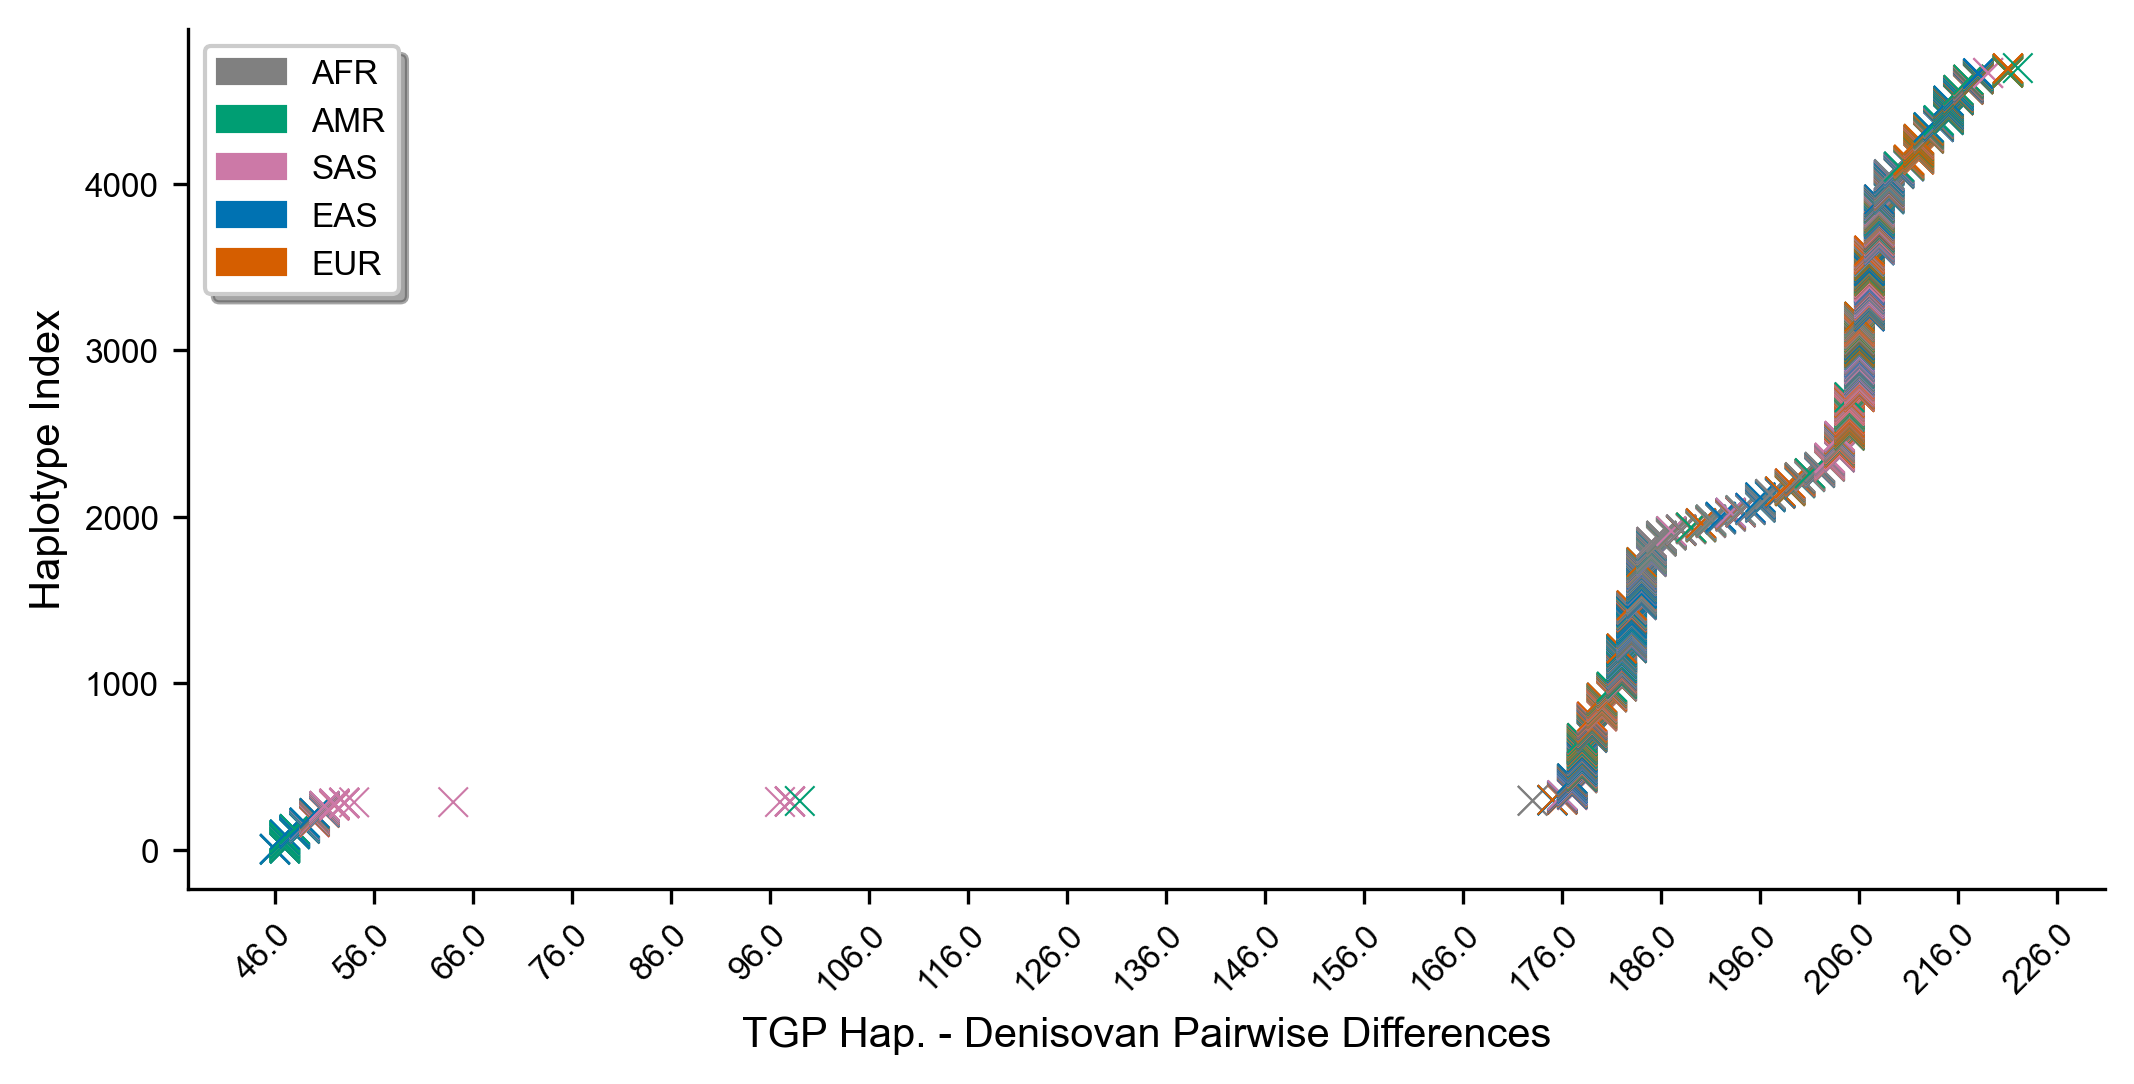

In [18]:
# Plot the denisovan s curve.
plot_s_curve('DEN', tgp_arc_hap_dists_72kb, tgp_info, 'tgp')

In [19]:
# Determine the haplotype indicies.
extract_den_rec_hum_hap_indicies(tgp_arc_hap_dists_72kb, 70, 100, 'tgp', 72)

In [20]:
# Show the denisovan-like haplotype summary.
compile_tgp_den_hap_freqs(72)

,spop,pop,n_haps,n_den_haps,den_hap_freq
0,AFR,LWK,198,0,0.000000
1,AFR,GWD,226,0,0.000000
2,AFR,MSL,170,0,0.000000
3,AFR,ESN,198,0,0.000000
4,AFR,YRI,216,0,0.000000
5,AMR,MXL,128,39,0.304688
6,AMR,PEL,170,37,0.217647
7,AMR,CLM,188,13,0.069149
8,AMR,PUR,208,18,0.086538
9,SAS,BEB,172,24,0.139535


### SGDP

In [21]:
# Load the meta data file for the TGP.
sgdp_df = pd.read_csv(
    '../meta_data/sgdp.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Construct the final dictionaries.
sgdp_info = {key: np.array(value) for key, value in sgdp_df.to_dict(orient='list').items()}

In [22]:
# Intialize the haplotype distances.
sgdp_arc_hap_dists_72kb = init_hap_dist_dicc('sgdp', 72)

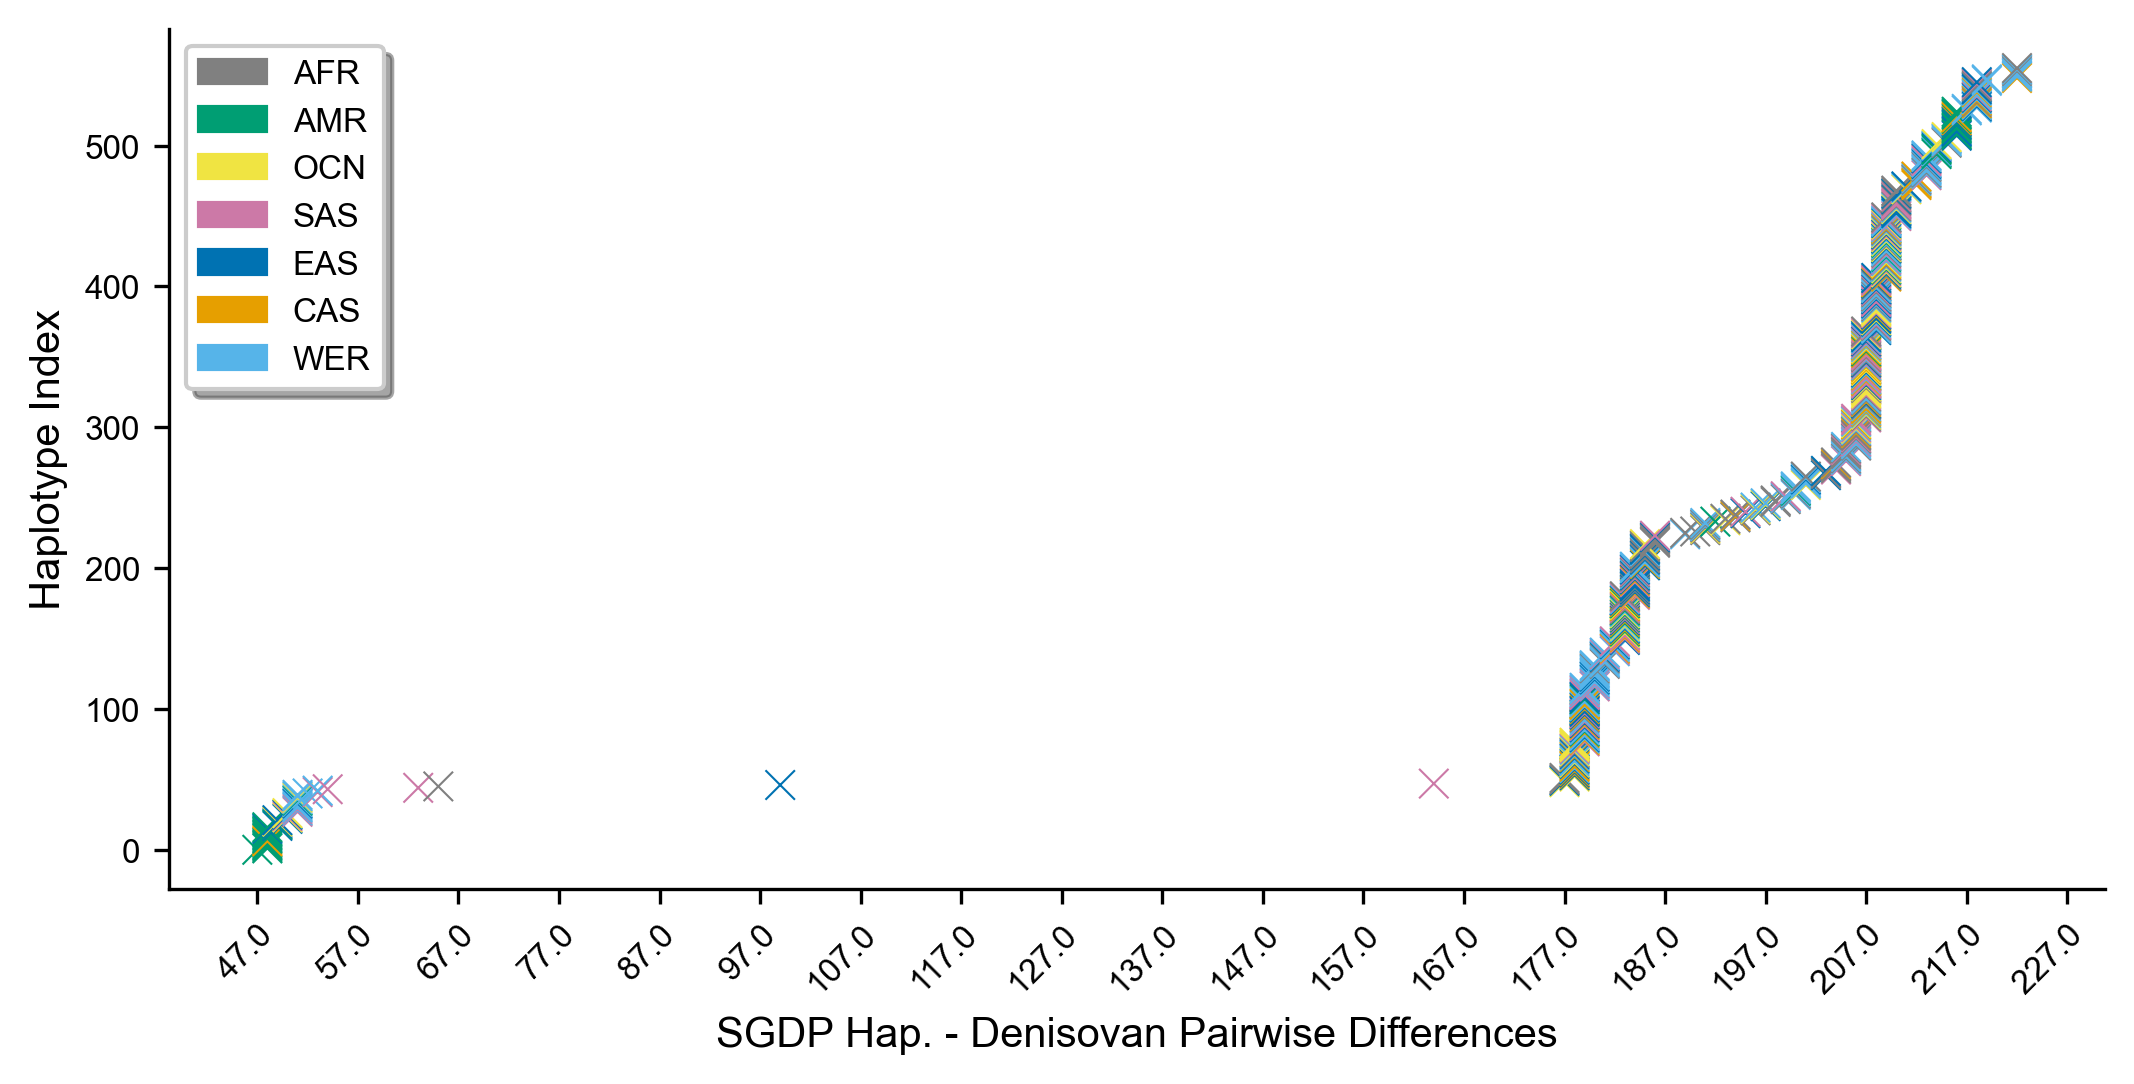

In [23]:
# Plot the denisovan s curve.
plot_s_curve('DEN', sgdp_arc_hap_dists_72kb, sgdp_info, 'sgdp')

## TGP `hmmix` Tracts

In [24]:
# Define a function to find tracts with any overlap of a region.
def tract_any_overlap(tracts_df, start, end):
    # Intialize a set to store tract indicies.
    tract_idx = set()
    # For every row in the qc'ed tracts.
    for _, row in tracts_df.iterrows():
        # If this tract has any overlap with the gene.
        if ((row['START'] <= start < row['END']) or         # t_s---s---t_e---e
            (row['START'] <= end < row['END']) or           # s---t_s---e---t_e
            (start >= row['START'] and end < row['END']) or # t_s---s---e---t_e
            (start <= row['START'] and end > row['END'])):  # s---t_s---t_e---e:
            # Update the set.
            tract_idx.add(row.name)
    return tracts_df.iloc[np.sort(np.array(list(tract_idx))), :].reset_index(drop=True)

# Define a function to qc the output of hmmix for the tgp.
def qc_tgp_hmmix_tracts():
    # Load in the meta information as a pandas dataframe.
    tgp_df = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Intialize an ordered dictionary.
    ooa_dicc = {
        'AMR': ['MXL', 'PEL', 'CLM', 'PUR'],
        'SAS': ['BEB', 'STU', 'ITU', 'PJL', 'GIH'],
        'EAS': ['CHB', 'KHV', 'CHS', 'JPT', 'CDX'],
        'EUR': ['TSI', 'CEU', 'IBS', 'GBR', 'FIN'],
    }
    # Intialize a list to store the tracts.
    qced_hmmix_tracts = []
    # For every super population.
    for spop in ooa_dicc:
        # For every population.
        for pop in ooa_dicc[spop]:
            # Extract the individuals in the population.
            inds = tgp_df[tgp_df['POP'] == pop]['IND'].values
            # For every individual.
            for ind in inds:
                # For each haplotype.
                for hap in ['hap1', 'hap2']:
                    # Load the dataframe.
                    tracts = pd.read_csv(
                        f'../tgp_hmmmix_haploid_tracts_per_ind/decoded.{ind}.autosome.{hap}.txt', sep='\t',
                    )
                    # Filter by posterior probability.
                    qced_cond = (tracts['mean_prob'].values >= 0.8) & (tracts['chrom'].values == '12') & (tracts['state'].values == 'Archaic')
                    qced_tracts = tracts[qced_cond]
                    # Make a copy.
                    qced_tracts = qced_tracts.copy()
                    # Adjust the columns as the length column is correct but the coordinates do not correspond,
                    # to the VCF coordinates, for more info see: https://github.com/LauritsSkov/Introgression-detection/pull/5
                    qced_tracts['start'] = qced_tracts['start'] + 1
                    qced_tracts['end'] = qced_tracts['end'] + 1001
                    # Generate additional columns.
                    qced_tracts['ind'] = np.full(qced_tracts.shape[0], f'{ind}-{hap}')
                    qced_tracts['spop'] = np.full(qced_tracts.shape[0], spop)
                    qced_tracts['pop'] = np.full(qced_tracts.shape[0], pop)
                    # Fill the dictionary.
                    qced_hmmix_tracts.append(qced_tracts)
    # Concatenate the results for all individuals.
    qced_hmmix_tracts_df = pd.concat(qced_hmmix_tracts).reset_index(drop=True)
    # Rename the columns.
    cleaned_qced_hmmix_tracts_df = qced_hmmix_tracts_df.rename(columns={
        'ind': 'IND', 'chrom': 'CHR', 'start': 'START', 'end': 'END',
        'length': 'LENGTH', 'state': 'STATE', 'snps': 'N_SNPS', 'admixpopvariants': 'N_ARC_SNPS',
        'pop':'POP', 'spop': 'SUPERPOP', 'mean_prob': 'PROB', 'AltaiNeandertal': 'N_ALT_SNPS',
        'Denisova': 'N_DEN_SNPS', 'Vindija33.19': 'N_VIN_SNPS', 'Chagyrskaya-Phalanx': 'N_CHA_SNPS',
    })
    # Intialize the column order.
    col_dicc = {
        'ind': 'IND', 'chrom': 'CHR', 'start': 'START', 'end': 'END',
        'length': 'LENGTH', 'state': 'STATE', 'snps': 'N_SNPS', 'admixpopvariants': 'N_ARC_SNPS',
        'pop':'POP', 'spop': 'SUPERPOP', 'mean_prob': 'PROB', 'AltaiNeandertal': 'N_ALT_SNPS',
        'Denisova': 'N_DEN_SNPS', 'Vindija33.19': 'N_VIN_SNPS', 'Chagyrskaya-Phalanx': 'N_CHA_SNPS',
    }
    col_order = [col_dicc[key] for key in col_dicc]
    # Reorder the columns.
    cleaned_qced_hmmix_tracts_chr12_df = cleaned_qced_hmmix_tracts_df[col_order]
    # Determine the tracts that overlap muc19 by at least one base pair.
    cleaned_qced_hmmix_tracts_muc19_df = tract_any_overlap(cleaned_qced_hmmix_tracts_chr12_df, 40787196, 40964559)
    # Export the qc'ed tracts.
    cleaned_qced_hmmix_tracts_chr12_df.to_csv('../hmmix_tracts/tgp_hmmix_haplotype_tracts_chr12.csv.gz', index=False)
    cleaned_qced_hmmix_tracts_muc19_df.to_csv('../hmmix_tracts/tgp_hmmix_haplotype_tracts_muc19.csv.gz', index=False)
    return

In [25]:
# QC the tgp hmmix tracts.
qc_tgp_hmmix_tracts()

## Denisovan `hmmix` Tracts in Papuans

In [26]:
# Define a function to qc the output of hmmix for the sgdp.
def qc_papuan_hmmix_tracts():
    # Load in the meta information as a pandas dataframe.
    sgdp_df = pd.read_csv(
        '../meta_data/sgdp.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Subset the Papuan individuals.
    pap_df = sgdp_df[sgdp_df['POP'] == 'Papuan']
    # Extract the information.
    inds = pap_df['IND'].values
    pops = pap_df['POP'].values
    spops = pap_df['SUPERPOP'].values
    # Intialize a list to store the tracts.
    qced_hmmix_tracts = []
    # For every individual.
    for ind, pop, spop in zip(inds, pops, spops):
        # For each haplotype.
        for hap in ['hap1', 'hap2']:
            # Load the dataframe.
            tracts = pd.read_csv(
                f'../papuan_phased_hmmmix_haploid_tracts_per_ind/decoded.{ind}.{hap}.txt', sep='\t',
            )
            # Filter by posterior probability.
            qced_cond = (tracts['mean_prob'].values >= 0.8) & (tracts['state'].values == 'Archaic')
            qced_tracts = tracts[qced_cond]
            # Make a copy.
            qced_tracts = qced_tracts.copy()
            # Adjust the columns as the length column is correct but the coordinates do not correspond,
            # to the VCF coordinates, for more info see: https://github.com/LauritsSkov/Introgression-detection/pull/5
            qced_tracts['start'] = qced_tracts['start'] + 1
            qced_tracts['end'] = qced_tracts['end'] + 1001
            # Generate additional columns.
            qced_tracts['ind'] = np.full(qced_tracts.shape[0], f'{ind}-{hap}')
            qced_tracts['spop'] = np.full(qced_tracts.shape[0], spop)
            qced_tracts['pop'] = np.full(qced_tracts.shape[0], pop)
            # Fill the dictionary.
            qced_hmmix_tracts.append(qced_tracts)
    # Concatenate the results for all individuals.
    qced_hmmix_tracts_df = pd.concat(qced_hmmix_tracts).reset_index(drop=True)
    # Rename the columns.
    cleaned_qced_hmmix_tracts_df = qced_hmmix_tracts_df.rename(columns={
        'ind': 'IND', 'chrom': 'CHR', 'start': 'START', 'end': 'END',
        'length': 'LENGTH', 'state': 'STATE', 'snps': 'N_SNPS', 'admixpopvariants': 'N_ARC_SNPS',
        'pop':'POP', 'spop': 'SUPERPOP', 'mean_prob': 'PROB', 'AltaiNeandertal': 'N_ALT_SNPS',
        'Denisova': 'N_DEN_SNPS', 'Vindija33.19': 'N_VIN_SNPS', 'Chagyrskaya-Phalanx': 'N_CHA_SNPS',
    })
    # Intialize the column order.
    col_dicc = {
        'ind': 'IND', 'chrom': 'CHR', 'start': 'START', 'end': 'END',
        'length': 'LENGTH', 'state': 'STATE', 'snps': 'N_SNPS', 'admixpopvariants': 'N_ARC_SNPS',
        'pop':'POP', 'spop': 'SUPERPOP', 'mean_prob': 'PROB', 'AltaiNeandertal': 'N_ALT_SNPS',
        'Denisova': 'N_DEN_SNPS', 'Vindija33.19': 'N_VIN_SNPS', 'Chagyrskaya-Phalanx': 'N_CHA_SNPS',
    }
    col_order = [col_dicc[key] for key in col_dicc]
    # Reorder the columns.
    cleaned_qced_hmmix_tracts_df = cleaned_qced_hmmix_tracts_df[col_order]
    # Export the qc'ed tracts.
    cleaned_qced_hmmix_tracts_df.to_csv('../hmmix_tracts/papuan_hmmix_haplotype_tracts.csv.gz', index=False)
    return

# Define a function to extract the Denisovan tracts in papuan individuals.
def extract_den_intro_tracts_in_papuans():
    # Define a list of papuan individuals in the sgdp.
    pap_inds = np.array([
        'S_Papuan-1.DG', 'S_Papuan-2.DG', 'S_Papuan-3.DG', 'S_Papuan-4.DG',
        'S_Papuan-5.DG', 'S_Papuan-6.DG', 'S_Papuan-7.DG', 'S_Papuan-8.DG',
        'S_Papuan-9.DG', 'S_Papuan-10.DG', 'S_Papuan-11.DG', 'S_Papuan-12.DG',
        'S_Papuan-13.DG', 'S_Papuan-14.DG', 'B_Papuan-15.DG',
    ])
    # Load the papuan tracts.
    pap_tracts_df = pd.read_csv('../hmmix_tracts/papuan_hmmix_haplotype_tracts.csv.gz')
    # Extract only the archaic snp counts as a numpy array.
    arc_snp_mat = pap_tracts_df[['N_DEN_SNPS', 'N_ALT_SNPS', 'N_VIN_SNPS', 'N_CHA_SNPS']].to_numpy()
    # Determine the rows where the denisovan has more snps than the neanderthals.
    den_snp_cond = (arc_snp_mat[:, 0] > arc_snp_mat[:, 1]) & (arc_snp_mat[:, 0] > arc_snp_mat[:, 2]) & (arc_snp_mat[:, 0] > arc_snp_mat[:, 3])
    # Filter for the denisovan autosomal tracts.
    pap_den_tracts_df = pap_tracts_df[den_snp_cond].reset_index(drop=True)
    # Adjust the coordinates for inclusive 1-based indexing.
    pap_den_tracts_df['END'] = pap_den_tracts_df['END'] - 1
    # For every sgdp papuan individual.
    for pap in pap_inds:
        # For each haplotype.
        for hap in ['hap1', 'hap2']:
            # Subset the dataframe. 
            pap_df = pap_den_tracts_df[pap_den_tracts_df['IND'] == f'{pap}-{hap}']
            # Intialize a dictionary.
            pap_tracts = {
                'chrom': [], 'start': [], 'end': [],
            }
            # For every chromosome.
            for chrom in range(1, 23):
                # Subset and sort the dataframe.
                sub_df = pap_df[pap_df['CHR'] == chrom].sort_values(by='START')
                # Update the dictionary.
                pap_tracts['chrom'].append(np.full(sub_df.shape[0], chrom))
                pap_tracts['start'].append(sub_df['START'].values)
                pap_tracts['end'].append(sub_df['END'].values)
            # For every key.
            for key in pap_tracts:
                # Concatenate all the arrays.
                pap_tracts[key] = np.concatenate(pap_tracts[key])
            # Convert to a dataframe.
            pap_hap_den_tracts_df = pd.DataFrame(pap_tracts)
            # Export the individuals tracts.
            pap_hap_den_tracts_df.to_csv(f'../hmmix_tracts/den_tracts_in_pap/den_intro_tracts_in_{pap}_{hap}.csv.gz', index=False)
    return

In [27]:
# QC the papuan tracts.
qc_papuan_hmmix_tracts()
# Extract the Denisovan introgressed tracts in Papuans.
extract_den_intro_tracts_in_papuans()

## `SPrime` SNPs for _PBS_

In [28]:
# Intialize a dictionary to store the archaic positions.
mxl_sprime_dicc = {}
# For every chromosome.
for i in range(1, 23):
    # Intialize a subdictionary.
    mxl_sprime_dicc[i] = {}
    # Load the sprime tracts for MXL.
    mxl_sprime_df = pd.read_csv(f'../sprime_tgp_pap/mendeley_data/MXL.chr{i}.ND_match', sep='\t')
    # Determine the sites that match each archaic.
    den_match_mask = mxl_sprime_df['DMATCH'] == 'match'
    alt_match_mask = mxl_sprime_df['NMATCH'] == 'match'
    # Fill the dictionary.
    mxl_sprime_dicc[i]['DEN'] = mxl_sprime_df[den_match_mask]['POS'].values
    mxl_sprime_dicc[i]['ALT'] = mxl_sprime_df[alt_match_mask]['POS'].values

In [29]:
# Intialize dictionaries.
mxl_sprime_pos = {}
mxl_sprime_summary = {
    'chrom': [], 'all_arc': [], 'shr_arc': [],
    'all_den': [], 'uniq_den': [],
    'all_alt': [], 'uniq_alt': [],
}
# For every chromosome.
for i in range(1, 23):
    # Intialize a subdictionary.
    mxl_sprime_pos[i] = {}
    # Determine the archaic unique positions.
    den_uniq = np.setdiff1d(mxl_sprime_dicc[i]['DEN'], mxl_sprime_dicc[i]['ALT'])
    alt_uniq = np.setdiff1d(mxl_sprime_dicc[i]['ALT'], mxl_sprime_dicc[i]['DEN'])
    # Determine the sites that are shared.
    shr_arc = np.intersect1d(mxl_sprime_dicc[i]['DEN'], mxl_sprime_dicc[i]['ALT'])
    # Determine which sites have any archaic alleles.
    all_arc = np.union1d(mxl_sprime_dicc[i]['DEN'], mxl_sprime_dicc[i]['ALT'])
    # Fill the dictionaries.
    mxl_sprime_pos[i]['all_den'] = mxl_sprime_dicc[i]['DEN']
    mxl_sprime_pos[i]['all_alt'] = mxl_sprime_dicc[i]['ALT']
    mxl_sprime_pos[i]['all_arc'] = all_arc
    mxl_sprime_pos[i]['uniq_den'] = den_uniq
    mxl_sprime_pos[i]['uniq_alt'] = alt_uniq
    mxl_sprime_pos[i]['shr_arc'] = shr_arc
    mxl_sprime_summary['chrom'].append(i)
    mxl_sprime_summary['all_den'].append(mxl_sprime_dicc[i]['DEN'].size)
    mxl_sprime_summary['all_alt'].append(mxl_sprime_dicc[i]['ALT'].size)
    mxl_sprime_summary['all_arc'].append(all_arc.size)
    mxl_sprime_summary['uniq_den'].append(den_uniq.size)
    mxl_sprime_summary['uniq_alt'].append(alt_uniq.size)
    mxl_sprime_summary['shr_arc'].append(shr_arc.size)
# Convert the dictionary to a datframe.
mxl_sprime_summary_df = pd.DataFrame(mxl_sprime_summary)

In [30]:
# Show the summary.
mxl_sprime_summary_df

,chrom,all_arc,shr_arc,all_den,uniq_den,all_alt,uniq_alt
0,1,7767,2143,2487,344,7423,5280
1,2,6915,1909,2348,439,6476,4567
2,3,6260,1540,1727,187,6073,4533
3,4,7066,1697,1971,274,6792,5095
4,5,4778,1389,1701,312,4466,3077
5,6,6758,1745,2377,632,6126,4381
6,7,5489,1635,2173,538,4951,3316
7,8,4288,1255,1420,165,4123,2868
8,9,4358,883,1093,210,4148,3265
9,10,5284,1278,1591,313,4971,3693


In [31]:
# For every chromosome.
# for i in range(1, 23):
#     # For every archaic site type.
#     for arc_type in mxl_sprime_pos[i]:
#         # Export the sprime positions.
#         np.savetxt(
#             f'../meta_data/mxl_sprime_all_arc_sites_chr{i}.txt.gz',
#             [mxl_sprime_pos[i]['all_arc']], fmt='%d',
#         )

## Files for _PBS_ Simulations

__Mutation Rate Map from ARGweaver__

```bash
# Load bedtools.
module load bedtools2

# Generate bed files.
bedtools intersect -a subst_rate_autosome.bed.gz -b 72kb_region.bed -wo > subst_rate_72kb.bed
bedtools intersect -a subst_rate_autosome.bed.gz -b 742kb_region.bed -wo > subst_rate_742kb.bed
```

__HapMap Genetic Map__

Let $d$ represent the genetic distance between two loci in units of cM, let $l$ represent the physical distance between two loci in units of bp, and given that $1 \text{cM} = 1\%$ probability of a recombination event per generation then:
$$
\mathbb{Pr}\left( \frac{\text{crossover}}{\text{bp}} \right) = \frac{d}{100 \times l} \,.
$$

In [32]:
# Read in the dataframes.
subst_72kb_df = pd.read_csv(
    '../annotations/rate_files/subst_rate_72kb.bed',
    usecols=[3, 7], sep='\t', names=['mu', 'bp']
)
subst_742kb_df = pd.read_csv(
    '../annotations/rate_files/subst_rate_742kb.bed',
    usecols=[3, 7], sep='\t', names=['mu', 'bp']
)
# Extract the rates and weights.
mu_72kb = subst_72kb_df['mu'].values
mu_w_72kb = subst_72kb_df['bp'].values / subst_72kb_df['bp'].sum()
mu_742kb = subst_742kb_df['mu'].values
mu_w_742kb = subst_742kb_df['bp'].values / subst_742kb_df['bp'].sum()

In [33]:
# Load the genetic map.
# Note: this file is 0-indexed which is needed for slim so I subtract 1 from the inclusive start and leave the inclusive end alone.
hap_map_df = pd.read_csv(
    '../annotations/rate_files/genetic_map_GRCh37_chr12.txt', sep='\t',
)
# Extract the physical and genetic positions.
hap_map_p_pos = hap_map_df['Position(bp)'].values
hap_map_g_pos = hap_map_df['Map(cM)'].values
# Find the closest poistion to the start of each region.
close_to_start_742kb = hap_map_p_pos[hap_map_p_pos <= 40272001-1].max()
close_to_start_72kb = hap_map_p_pos[hap_map_p_pos <= 40759001-1].max()
# Create region masks.
hap_map_mask_742kb = (close_to_start_742kb <= hap_map_p_pos) & (hap_map_p_pos <= 41014000)
hap_map_mask_72kb = (close_to_start_72kb <= hap_map_p_pos) & (hap_map_p_pos <= 40831000)
# Mask the dataframes.
hap_map_742kb_df = hap_map_df[hap_map_mask_742kb]
hap_map_72kb_df = hap_map_df[hap_map_mask_72kb]

In [34]:
## 742kb Rec. Rate File ##
# Intialize the start and stop positions for the region.
start_p_pos_742kb = 40272001-1
stop_p_pos_742kb = 41014000
# Interporlate the genetic positions based on all of chromosome 12.
start_g_pos_742kb = np.interp(start_p_pos_742kb, hap_map_p_pos, hap_map_g_pos)
stop_g_pos_742kb = np.interp(stop_p_pos_742kb, hap_map_p_pos, hap_map_g_pos)
# Intialize interval lists.
rec_map_starts_742kb = []
rec_map_stops_742kb = []
rec_map_spans_742kb = []
rec_map_rates_742kb = []
# Extract the phyiscal and genetic positions and rates.
hap_map_742kb_p_pos = hap_map_742kb_df['Position(bp)'].values
hap_map_742kb_g_pos = hap_map_742kb_df['Map(cM)'].values
hap_map_742kb_rates = hap_map_742kb_df['Rate(cM/Mb)'].values
# For every position.
for i, pos in enumerate(hap_map_742kb_p_pos):
    # If this is the first position.
    if i == 0:
        # Compute the span of the interval.
        p_span_742kb = hap_map_742kb_p_pos[i+1] - start_p_pos_742kb
        # Compute the per generation per base pair recombination rate.
        r_742kb = (hap_map_742kb_g_pos[i+1] - start_g_pos_742kb) / (p_span_742kb * 100)
        # Update the current interval's information
        rec_map_starts_742kb.append(start_p_pos_742kb)
        rec_map_stops_742kb.append(hap_map_742kb_p_pos[i+1])
        rec_map_spans_742kb.append(p_span_742kb)
        rec_map_rates_742kb.append(r_742kb)
    # Else-if this is the last position.
    elif i == (hap_map_742kb_p_pos.size - 1):
        # Compute the span of the interval.
        p_span_742kb = stop_p_pos_742kb - hap_map_742kb_p_pos[i]
        # Compute the per generation per base pair recombination rate.
        r_742kb = (stop_g_pos_742kb - hap_map_742kb_g_pos[i]) / (p_span_742kb * 100)
        # Update the current interval's information
        rec_map_starts_742kb.append(hap_map_742kb_p_pos[i])
        rec_map_stops_742kb.append(stop_p_pos_742kb)
        rec_map_spans_742kb.append(p_span_742kb)
        rec_map_rates_742kb.append(r_742kb)
    # Else, this is not the region's first or last position edge case.
    else:
        # Compute the span of the interval.
        p_span_742kb = hap_map_742kb_p_pos[i+1] - hap_map_742kb_p_pos[i]
        # Compute the per generation per base pair recombination rate.
        r_742kb = (hap_map_742kb_g_pos[i+1] - hap_map_742kb_g_pos[i]) / (p_span_742kb * 100)
        # Update the current interval's information
        rec_map_starts_742kb.append(hap_map_742kb_p_pos[i])
        rec_map_stops_742kb.append(hap_map_742kb_p_pos[i+1])
        rec_map_spans_742kb.append(p_span_742kb)
        rec_map_rates_742kb.append(r_742kb)
# Intitialize a dictionary.
rec_info_742kb = {
    'start': np.array(rec_map_starts_742kb, dtype=int), 'stop': np.array(rec_map_stops_742kb, dtype=int),
    'span': np.array(rec_map_spans_742kb, dtype=int), 'rec_rate': np.array(rec_map_rates_742kb),
}
# Convert the dictionary to a dataframe.
rec_info_742kb_df = pd.DataFrame(rec_info_742kb)

In [35]:
## 72kb Rec. Rate File ##
# Intialize the start and stop positions for the region.
start_p_pos_72kb = 40759001-1
stop_p_pos_72kb = 40831000
# Interporlate the genetic positions based on all of chromosome 12.
start_g_pos_72kb = np.interp(start_p_pos_72kb, hap_map_p_pos, hap_map_g_pos)
stop_g_pos_72kb = np.interp(stop_p_pos_72kb, hap_map_p_pos, hap_map_g_pos)
# Intialize interval lists.
rec_map_starts_72kb = []
rec_map_stops_72kb = []
rec_map_spans_72kb = []
rec_map_rates_72kb = []
# Extract the phyiscal and genetic positions and rates.
hap_map_72kb_p_pos = hap_map_72kb_df['Position(bp)'].values
hap_map_72kb_g_pos = hap_map_72kb_df['Map(cM)'].values
hap_map_72kb_rates = hap_map_72kb_df['Rate(cM/Mb)'].values
# For every position.
for i, pos in enumerate(hap_map_72kb_p_pos):
    # If this is the first position.
    if i == 0:
        # Compute the span of the interval.
        p_span_72kb = hap_map_72kb_p_pos[i+1] - start_p_pos_72kb
        # Compute the per generation per base pair recombination rate.
        r_72kb = (hap_map_72kb_g_pos[i+1] - start_g_pos_72kb) / (p_span_72kb * 100)
        # Update the current interval's information
        rec_map_starts_72kb.append(start_p_pos_72kb)
        rec_map_stops_72kb.append(hap_map_72kb_p_pos[i+1])
        rec_map_spans_72kb.append(p_span_72kb)
        rec_map_rates_72kb.append(r_72kb)
    # Else-if this is the last position.
    elif i == (hap_map_72kb_p_pos.size - 1):
        # Compute the span of the interval.
        p_span_72kb = stop_p_pos_72kb - hap_map_72kb_p_pos[i]
        # Compute the per generation per base pair recombination rate.
        r_72kb = (stop_g_pos_72kb - hap_map_72kb_g_pos[i]) / (p_span_72kb * 100)
        # Update the current interval's information
        rec_map_starts_72kb.append(hap_map_72kb_p_pos[i])
        rec_map_stops_72kb.append(stop_p_pos_72kb)
        rec_map_spans_72kb.append(p_span_72kb)
        rec_map_rates_72kb.append(r_72kb)
    # Else, this is not the region's first or last position edge case.
    else:
        # Compute the span of the interval.
        p_span_72kb = hap_map_72kb_p_pos[i+1] - hap_map_72kb_p_pos[i]
        # Compute the per generation per base pair recombination rate.
        r_72kb = (hap_map_72kb_g_pos[i+1] - hap_map_72kb_g_pos[i]) / (p_span_72kb * 100)
        # Update the current interval's information
        rec_map_starts_72kb.append(hap_map_72kb_p_pos[i])
        rec_map_stops_72kb.append(hap_map_72kb_p_pos[i+1])
        rec_map_spans_72kb.append(p_span_72kb)
        rec_map_rates_72kb.append(r_72kb)
# Intitialize a dictionary.
rec_info_72kb = {
    'start': np.array(rec_map_starts_72kb, dtype=int), 'stop': np.array(rec_map_stops_72kb, dtype=int),
    'span': np.array(rec_map_spans_72kb, dtype=int), 'rec_rate': np.array(rec_map_rates_72kb),
}
# Convert the dictionary to a dataframe.
rec_info_72kb_df = pd.DataFrame(rec_info_72kb)

In [36]:
# Export the files.
# rec_info_742kb_df.to_csv('../meta_data/slim_hap_map_rec_rates_742kb.csv.gz', index=False)
# rec_info_72kb_df.to_csv('../meta_data/slim_hap_map_rec_rates_72kb.csv.gz', index=False)
# Print a summary.
print('#***# Mean Recombination and Mutation Rates in the 742kb Focal Region #***#')
print(f'r = {(stop_g_pos_742kb - start_g_pos_742kb) / ((stop_p_pos_742kb - start_p_pos_742kb) * 100)}')
print(f'mu = {(mu_742kb * subst_742kb_df["bp"].values).sum() / subst_742kb_df["bp"].sum()}')
print('\n')
print('#***# Mean Recombination and Mutation Rates in the 72kb Focal Region #***#')
print(f'r = {(stop_g_pos_72kb - start_g_pos_72kb) / ((stop_p_pos_72kb - start_p_pos_72kb) * 100)}')
print(f'mu = {(mu_72kb * subst_72kb_df["bp"].values).sum() / subst_72kb_df["bp"].sum()}')

#***# Mean Recombination and Mutation Rates in the 742kb Focal Region #***#
r = 5.999665348061085e-09
mu = 1.3154071069676549e-08


#***# Mean Recombination and Mutation Rates in the 72kb Focal Region #***#
r = 1.033940787320553e-08
mu = 1.4419662784722223e-08


## Files for Phasing

In [37]:
# Load the genotype matrix.
tgp_arcs_no_aa_72kb_gt, tgp_arcs_no_aa_72kb_pos = load_hap_region('tgp_arcs_masked_no_aa', 12, 40759001, 40831000)

### Region Files for Phasing

 * Synthetic Neandethal: [({CHA Passes QC} $\cup$ {VIN Passes QC}) $\cap$ ({DEN Passes QC} $\cap$ {ALT Passes QC}) $\cap$ {TGP Seg. Sites}] $\cup$ [({DEN-ALT Fixed Diff.} $\cap$ {TGP Invar. Sites}) $\cup$ ({CHA Het. Sites} $\cup$ {VIN Het. Sites})]
      * Sites where CHA or VIN passes QC and where DEN and ALT pass QC that are segregating in the TGP and the sites that are heterozygous in CHA or VIN that are invariant in the TGP and fixed differences between DEN and ALT.
* Chagyrskaya Neandethal: ({CHA Passes QC} $\cap$ {TGP Seg. Sites}) $\cup$ [({DEN-ALT Fixed Diff.} $\cap$ {TGP Invar. Sites}) $\cup$ {CHA Het. Sites}]
     * Sites where CHA passes QC that are segregating in the TGP and the sites that are heterozygous in CHA that are invariant in the TGP and fixed differences between DEN and ALT.
* Vindija Neandethal: ({VIN Passes QC} $\cap$ {TGP Seg. Sites}) $\cup$ [({DEN-ALT Fixed Diff.} $\cap$ {TGP Invar. Sites}) $\cup$ {VIN Het. Sites}]
     * Sites where VIN passes QC that are segregating in the TGP and the sites that are heterozygous in VIN that are invariant in the TGP and fixed differences between DEN and ALT.

In [38]:
# Intialize the archaic indicies.
arc_idx = {
    'ALT': np.array([2347]), 'CHA': np.array([2348]),
    'VIN': np.array([2349]), 'DEN': np.array([2350]),
}
# Compute allele frequencies per archaic.
den_freqs = calc_ind_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(arc_idx['DEN'], axis=1))
alt_freqs = calc_ind_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(arc_idx['ALT'], axis=1))
cha_freqs = calc_ind_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(arc_idx['CHA'], axis=1))
vin_freqs = calc_ind_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(arc_idx['VIN'], axis=1))
# Determine the sites that passed qc per archaic.
den_is_qced = ~np.isnan(den_freqs)
alt_is_qced = ~np.isnan(alt_freqs)
cha_is_qced = ~np.isnan(cha_freqs)
vin_is_qced = ~np.isnan(vin_freqs)
# Create masks for heterozygous sites in the late neanderthals.
cha_is_het = cha_freqs == 0.5
vin_is_het = vin_freqs == 0.5
# Create a mask for the denisovan v altai neanderthal fixed differences.
den_alt_is_fxd = pwd_per_site(den_freqs, alt_freqs) == 1
# Identify positions that are segregating in the tgp.
tgp_is_seg = tgp_arcs_no_aa_72kb_gt.take(np.arange(2347), axis=1).count_alleles().is_segregating()

In [39]:
# Intialize the synthetic neanderthal phasing mask.
cha_or_vin_is_qced = cha_is_qced | vin_is_qced
den_and_alt_is_qced = den_is_qced & alt_is_qced
cha_or_vin_and_den_and_alt_is_qced = cha_or_vin_is_qced & den_and_alt_is_qced
cha_or_vin_and_den_and_alt_is_qced_and_tgp_is_seg = cha_or_vin_and_den_and_alt_is_qced & tgp_is_seg
cha_or_vin_is_het = cha_is_het | vin_is_het
den_alt_fxd_and_tgp_is_invar = den_alt_is_fxd & ~tgp_is_seg
cha_or_vin_is_het_and_den_alt_fxd_and_tgp_is_invar = cha_or_vin_is_het & den_alt_fxd_and_tgp_is_invar
syn_nea_pos_mask = cha_or_vin_and_den_and_alt_is_qced_and_tgp_is_seg | cha_or_vin_is_het_and_den_alt_fxd_and_tgp_is_invar

In [40]:
# Print a summary.
print('##***## Synthetic Neanderthal Phasing Info ##***##')
print(f'Number of heterozygous sites in either CHA or VIN: {cha_or_vin_is_het.sum()}')
print(f'Number of fixed differences b/w DEN and ALT: {den_alt_is_fxd.sum()}')
print(f'Number of variant sites in the 1KG: {tgp_is_seg.sum()}')
print(f'Number of invariant sites in the 1KG: {(~tgp_is_seg).sum()}')
print(f'Number of heterozygous sites to phase: {(den_alt_is_fxd & syn_nea_pos_mask).sum()}')

##***## Synthetic Neanderthal Phasing Info ##***##
Number of heterozygous sites in either CHA or VIN: 184
Number of fixed differences b/w DEN and ALT: 170
Number of variant sites in the 1KG: 1587
Number of invariant sites in the 1KG: 82
Number of heterozygous sites to phase: 155


In [41]:
# Intialize the cha phasing mask.
cha_is_qced_and_tgp_is_seg = cha_is_qced & tgp_is_seg
den_alt_fxd_and_tgp_is_invar = den_alt_is_fxd & ~tgp_is_seg
den_alt_fxd_and_tgp_is_invar_and_cha_is_het = den_alt_fxd_and_tgp_is_invar & cha_is_het
cha_pos_mask = cha_is_qced_and_tgp_is_seg | den_alt_fxd_and_tgp_is_invar_and_cha_is_het

In [42]:
# Print a summary.
print('##***## Chagyrskaya Neanderthal Phasing Info ##***##')
print(f'Number of heterozygous sites: {cha_is_het.sum()}')
print(f'Number of heterozygous sites to statistically phase: {(cha_pos_mask & cha_is_het).sum()}')
print(f'Number of heterozygous sites to resolve with read-based phasing: {cha_is_het.sum() - (cha_pos_mask & cha_is_het).sum()}')

##***## Chagyrskaya Neanderthal Phasing Info ##***##
Number of heterozygous sites: 167
Number of heterozygous sites to statistically phase: 163
Number of heterozygous sites to resolve with read-based phasing: 4


In [43]:
# Intialize the vin phasing mask.
vin_is_qced_and_tgp_is_seg = vin_is_qced & tgp_is_seg
den_alt_fxd_and_tgp_is_invar = den_alt_is_fxd & ~tgp_is_seg
den_alt_fxd_and_tgp_is_invar_and_vin_is_het = den_alt_fxd_and_tgp_is_invar & vin_is_het
vin_pos_mask = vin_is_qced_and_tgp_is_seg | den_alt_fxd_and_tgp_is_invar_and_vin_is_het

In [44]:
# Print a summary.
print('##***## Vindija Neanderthal Phasing Info ##***##')
print(f'Number of heterozygous sites: {vin_is_het.sum()}')
print(f'Number of heterozygous sites to statistically phase: {(vin_pos_mask & vin_is_het).sum()}')
print(f'Number of heterozygous sites to resolve with read-based phasing: {vin_is_het.sum() - (vin_pos_mask & vin_is_het).sum()}')

##***## Vindija Neanderthal Phasing Info ##***##
Number of heterozygous sites: 170
Number of heterozygous sites to statistically phase: 165
Number of heterozygous sites to resolve with read-based phasing: 5


In [45]:
# Create regions files for phasing.
syn_nea_pos_df = pd.DataFrame({
    'CHR': np.full(syn_nea_pos_mask.sum(), 12), 'POS': tgp_arcs_no_aa_72kb_pos[syn_nea_pos_mask],
})
cha_pos_df = pd.DataFrame({
    'CHR': np.full(cha_pos_mask.sum(), 12), 'POS': tgp_arcs_no_aa_72kb_pos[cha_pos_mask],
})
vin_pos_df = pd.DataFrame({
    'CHR': np.full(vin_pos_mask.sum(), 12), 'POS': tgp_arcs_no_aa_72kb_pos[vin_pos_mask],
})

In [46]:
# Export the regions files.
# syn_nea_pos_df.to_csv('../vcf_data/phasing/syn_to_phase_sites.txt', sep='\t', index=False, header=False)
# cha_pos_df.to_csv('../vcf_data/phasing/cha_to_phase_sites.txt', sep='\t', index=False, header=False)
# vin_pos_df.to_csv('../vcf_data/phasing/vin_to_phase_sites.txt', sep='\t', index=False, header=False)

### Synthetic Neanderthal Phasing VCF Files

Step 1. Converting the VCF to a Table
```bash
zcat tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps_syn_to_phase_sites.vcf.gz | grep -v '^##' | gzip > tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps_syn_to_phase_sites.txt.gz
```

Step 2. Grabbing the Header from the VCF
```bash
zcat tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps_syn_to_phase_sites.vcf.gz | grep '^##' > tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps_syn_to_phase_sites_header.txt
```

In [47]:
# Load in the observed genotype data for phasing.
obs_phasing_df = pd.read_csv(
    '../vcf_data/phasing/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps_syn_to_phase_sites.txt.gz',
    sep='\t',
)

In [48]:
# Drop the late neanderthals.
obs_phasing_df.drop(columns=['Chagyrskaya-Phalanx', 'Vindija33.19'], inplace=True)
# Grab the altai neanderthal and the denisovan columns.
alt_col = obs_phasing_df['AltaiNeandertal'].values
den_col = obs_phasing_df['Denisova'].values
# Clean the genotype information.
alt_genos = np.array([row[:3]+':.:.:.:.:.:.:.' for row in alt_col])
den_genos = np.array([row[:3]+':.:.:.:.:.:.:.' for row in den_col])
# Intialize lists to store genotypes.
syn_gt = []
alt_hap = []
den_hap = []
# For every position.
for pos in range(obs_phasing_df.shape[0]):
    # Update the genotype information.
    syn_gt.append(f'{den_genos[pos][0]}/{alt_genos[pos][2]}:.:.:.:.:.:.:.')
    den_hap.append(int(den_genos[pos][0]))
    alt_hap.append(int(alt_genos[pos][2]))
# Convert to numpy arrays.
syn_gt = np.array(syn_gt)
alt_hap = np.array(alt_hap)
den_hap = np.array(den_hap)
# Create a heterozygous mask for the synthetic indvidual.
syn_het_mask = np.array([(geno[:3] == '0/1' or geno[:3] == '1/0') for geno in syn_gt])
# Print a summary.
print(f'Synthetic Neanderthal Het. Sites: {syn_het_mask.sum()}')

Synthetic Neanderthal Het. Sites: 155


In [49]:
# Intialize the vcf header.
vcf_header = """##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##fileDate=20150218
##reference=ftp://ftp.1000genomes.ebi.ac.uk//vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz
##source=1000GenomesPhase3Pipeline
##contig=<ID=1,assembly=b37,length=249250621>
##contig=<ID=2,assembly=b37,length=243199373>
##contig=<ID=3,assembly=b37,length=198022430>
##contig=<ID=4,assembly=b37,length=191154276>
##contig=<ID=5,assembly=b37,length=180915260>
##contig=<ID=6,assembly=b37,length=171115067>
##contig=<ID=7,assembly=b37,length=159138663>
##contig=<ID=8,assembly=b37,length=146364022>
##contig=<ID=9,assembly=b37,length=141213431>
##contig=<ID=10,assembly=b37,length=135534747>
##contig=<ID=11,assembly=b37,length=135006516>
##contig=<ID=12,assembly=b37,length=133851895>
##contig=<ID=13,assembly=b37,length=115169878>
##contig=<ID=14,assembly=b37,length=107349540>
##contig=<ID=15,assembly=b37,length=102531392>
##contig=<ID=16,assembly=b37,length=90354753>
##contig=<ID=17,assembly=b37,length=81195210>
##contig=<ID=18,assembly=b37,length=78077248>
##contig=<ID=19,assembly=b37,length=59128983>
##contig=<ID=20,assembly=b37,length=63025520>
##contig=<ID=21,assembly=b37,length=48129895>
##contig=<ID=22,assembly=b37,length=51304566>
##contig=<ID=GL000191.1,assembly=b37,length=106433>
##contig=<ID=GL000192.1,assembly=b37,length=547496>
##contig=<ID=GL000193.1,assembly=b37,length=189789>
##contig=<ID=GL000194.1,assembly=b37,length=191469>
##contig=<ID=GL000195.1,assembly=b37,length=182896>
##contig=<ID=GL000196.1,assembly=b37,length=38914>
##contig=<ID=GL000197.1,assembly=b37,length=37175>
##contig=<ID=GL000198.1,assembly=b37,length=90085>
##contig=<ID=GL000199.1,assembly=b37,length=169874>
##contig=<ID=GL000200.1,assembly=b37,length=187035>
##contig=<ID=GL000201.1,assembly=b37,length=36148>
##contig=<ID=GL000202.1,assembly=b37,length=40103>
##contig=<ID=GL000203.1,assembly=b37,length=37498>
##contig=<ID=GL000204.1,assembly=b37,length=81310>
##contig=<ID=GL000205.1,assembly=b37,length=174588>
##contig=<ID=GL000206.1,assembly=b37,length=41001>
##contig=<ID=GL000207.1,assembly=b37,length=4262>
##contig=<ID=GL000208.1,assembly=b37,length=92689>
##contig=<ID=GL000209.1,assembly=b37,length=159169>
##contig=<ID=GL000210.1,assembly=b37,length=27682>
##contig=<ID=GL000211.1,assembly=b37,length=166566>
##contig=<ID=GL000212.1,assembly=b37,length=186858>
##contig=<ID=GL000213.1,assembly=b37,length=164239>
##contig=<ID=GL000214.1,assembly=b37,length=137718>
##contig=<ID=GL000215.1,assembly=b37,length=172545>
##contig=<ID=GL000216.1,assembly=b37,length=172294>
##contig=<ID=GL000217.1,assembly=b37,length=172149>
##contig=<ID=GL000218.1,assembly=b37,length=161147>
##contig=<ID=GL000219.1,assembly=b37,length=179198>
##contig=<ID=GL000220.1,assembly=b37,length=161802>
##contig=<ID=GL000221.1,assembly=b37,length=155397>
##contig=<ID=GL000222.1,assembly=b37,length=186861>
##contig=<ID=GL000223.1,assembly=b37,length=180455>
##contig=<ID=GL000224.1,assembly=b37,length=179693>
##contig=<ID=GL000225.1,assembly=b37,length=211173>
##contig=<ID=GL000226.1,assembly=b37,length=15008>
##contig=<ID=GL000227.1,assembly=b37,length=128374>
##contig=<ID=GL000228.1,assembly=b37,length=129120>
##contig=<ID=GL000229.1,assembly=b37,length=19913>
##contig=<ID=GL000230.1,assembly=b37,length=43691>
##contig=<ID=GL000231.1,assembly=b37,length=27386>
##contig=<ID=GL000232.1,assembly=b37,length=40652>
##contig=<ID=GL000233.1,assembly=b37,length=45941>
##contig=<ID=GL000234.1,assembly=b37,length=40531>
##contig=<ID=GL000235.1,assembly=b37,length=34474>
##contig=<ID=GL000236.1,assembly=b37,length=41934>
##contig=<ID=GL000237.1,assembly=b37,length=45867>
##contig=<ID=GL000238.1,assembly=b37,length=39939>
##contig=<ID=GL000239.1,assembly=b37,length=33824>
##contig=<ID=GL000240.1,assembly=b37,length=41933>
##contig=<ID=GL000241.1,assembly=b37,length=42152>
##contig=<ID=GL000242.1,assembly=b37,length=43523>
##contig=<ID=GL000243.1,assembly=b37,length=43341>
##contig=<ID=GL000244.1,assembly=b37,length=39929>
##contig=<ID=GL000245.1,assembly=b37,length=36651>
##contig=<ID=GL000246.1,assembly=b37,length=38154>
##contig=<ID=GL000247.1,assembly=b37,length=36422>
##contig=<ID=GL000248.1,assembly=b37,length=39786>
##contig=<ID=GL000249.1,assembly=b37,length=38502>
##contig=<ID=MT,assembly=b37,length=16569>
##contig=<ID=NC_007605,assembly=b37,length=171823>
##contig=<ID=X,assembly=b37,length=155270560>
##contig=<ID=Y,assembly=b37,length=59373566>
##contig=<ID=hs37d5,assembly=b37,length=35477943>
##ALT=<ID=CNV,Description="Copy Number Polymorphism">
##ALT=<ID=DEL,Description="Deletion">
##ALT=<ID=DUP,Description="Duplication">
##ALT=<ID=INS:ME:ALU,Description="Insertion of ALU element">
##ALT=<ID=INS:ME:LINE1,Description="Insertion of LINE1 element">
##ALT=<ID=INS:ME:SVA,Description="Insertion of SVA element">
##ALT=<ID=INS:MT,Description="Nuclear Mitochondrial Insertion">
##ALT=<ID=INV,Description="Inversion">
##ALT=<ID=CN0,Description="Copy number allele: 0 copies">
##ALT=<ID=CN1,Description="Copy number allele: 1 copy">
##ALT=<ID=CN2,Description="Copy number allele: 2 copies">
##ALT=<ID=CN3,Description="Copy number allele: 3 copies">
##ALT=<ID=CN4,Description="Copy number allele: 4 copies">
##ALT=<ID=CN5,Description="Copy number allele: 5 copies">
##ALT=<ID=CN6,Description="Copy number allele: 6 copies">
##ALT=<ID=CN7,Description="Copy number allele: 7 copies">
##ALT=<ID=CN8,Description="Copy number allele: 8 copies">
##ALT=<ID=CN9,Description="Copy number allele: 9 copies">
##ALT=<ID=CN10,Description="Copy number allele: 10 copies">
##ALT=<ID=CN11,Description="Copy number allele: 11 copies">
##ALT=<ID=CN12,Description="Copy number allele: 12 copies">
##ALT=<ID=CN13,Description="Copy number allele: 13 copies">
##ALT=<ID=CN14,Description="Copy number allele: 14 copies">
##ALT=<ID=CN15,Description="Copy number allele: 15 copies">
##ALT=<ID=CN16,Description="Copy number allele: 16 copies">
##ALT=<ID=CN17,Description="Copy number allele: 17 copies">
##ALT=<ID=CN18,Description="Copy number allele: 18 copies">
##ALT=<ID=CN19,Description="Copy number allele: 19 copies">
##ALT=<ID=CN20,Description="Copy number allele: 20 copies">
##ALT=<ID=CN21,Description="Copy number allele: 21 copies">
##ALT=<ID=CN22,Description="Copy number allele: 22 copies">
##ALT=<ID=CN23,Description="Copy number allele: 23 copies">
##ALT=<ID=CN24,Description="Copy number allele: 24 copies">
##ALT=<ID=CN25,Description="Copy number allele: 25 copies">
##ALT=<ID=CN26,Description="Copy number allele: 26 copies">
##ALT=<ID=CN27,Description="Copy number allele: 27 copies">
##ALT=<ID=CN28,Description="Copy number allele: 28 copies">
##ALT=<ID=CN29,Description="Copy number allele: 29 copies">
##ALT=<ID=CN30,Description="Copy number allele: 30 copies">
##ALT=<ID=CN31,Description="Copy number allele: 31 copies">
##ALT=<ID=CN32,Description="Copy number allele: 32 copies">
##ALT=<ID=CN33,Description="Copy number allele: 33 copies">
##ALT=<ID=CN34,Description="Copy number allele: 34 copies">
##ALT=<ID=CN35,Description="Copy number allele: 35 copies">
##ALT=<ID=CN36,Description="Copy number allele: 36 copies">
##ALT=<ID=CN37,Description="Copy number allele: 37 copies">
##ALT=<ID=CN38,Description="Copy number allele: 38 copies">
##ALT=<ID=CN39,Description="Copy number allele: 39 copies">
##ALT=<ID=CN40,Description="Copy number allele: 40 copies">
##ALT=<ID=CN41,Description="Copy number allele: 41 copies">
##ALT=<ID=CN42,Description="Copy number allele: 42 copies">
##ALT=<ID=CN43,Description="Copy number allele: 43 copies">
##ALT=<ID=CN44,Description="Copy number allele: 44 copies">
##ALT=<ID=CN45,Description="Copy number allele: 45 copies">
##ALT=<ID=CN46,Description="Copy number allele: 46 copies">
##ALT=<ID=CN47,Description="Copy number allele: 47 copies">
##ALT=<ID=CN48,Description="Copy number allele: 48 copies">
##ALT=<ID=CN49,Description="Copy number allele: 49 copies">
##ALT=<ID=CN50,Description="Copy number allele: 50 copies">
##ALT=<ID=CN51,Description="Copy number allele: 51 copies">
##ALT=<ID=CN52,Description="Copy number allele: 52 copies">
##ALT=<ID=CN53,Description="Copy number allele: 53 copies">
##ALT=<ID=CN54,Description="Copy number allele: 54 copies">
##ALT=<ID=CN55,Description="Copy number allele: 55 copies">
##ALT=<ID=CN56,Description="Copy number allele: 56 copies">
##ALT=<ID=CN57,Description="Copy number allele: 57 copies">
##ALT=<ID=CN58,Description="Copy number allele: 58 copies">
##ALT=<ID=CN59,Description="Copy number allele: 59 copies">
##ALT=<ID=CN60,Description="Copy number allele: 60 copies">
##ALT=<ID=CN61,Description="Copy number allele: 61 copies">
##ALT=<ID=CN62,Description="Copy number allele: 62 copies">
##ALT=<ID=CN63,Description="Copy number allele: 63 copies">
##ALT=<ID=CN64,Description="Copy number allele: 64 copies">
##ALT=<ID=CN65,Description="Copy number allele: 65 copies">
##ALT=<ID=CN66,Description="Copy number allele: 66 copies">
##ALT=<ID=CN67,Description="Copy number allele: 67 copies">
##ALT=<ID=CN68,Description="Copy number allele: 68 copies">
##ALT=<ID=CN69,Description="Copy number allele: 69 copies">
##ALT=<ID=CN70,Description="Copy number allele: 70 copies">
##ALT=<ID=CN71,Description="Copy number allele: 71 copies">
##ALT=<ID=CN72,Description="Copy number allele: 72 copies">
##ALT=<ID=CN73,Description="Copy number allele: 73 copies">
##ALT=<ID=CN74,Description="Copy number allele: 74 copies">
##ALT=<ID=CN75,Description="Copy number allele: 75 copies">
##ALT=<ID=CN76,Description="Copy number allele: 76 copies">
##ALT=<ID=CN77,Description="Copy number allele: 77 copies">
##ALT=<ID=CN78,Description="Copy number allele: 78 copies">
##ALT=<ID=CN79,Description="Copy number allele: 79 copies">
##ALT=<ID=CN80,Description="Copy number allele: 80 copies">
##ALT=<ID=CN81,Description="Copy number allele: 81 copies">
##ALT=<ID=CN82,Description="Copy number allele: 82 copies">
##ALT=<ID=CN83,Description="Copy number allele: 83 copies">
##ALT=<ID=CN84,Description="Copy number allele: 84 copies">
##ALT=<ID=CN85,Description="Copy number allele: 85 copies">
##ALT=<ID=CN86,Description="Copy number allele: 86 copies">
##ALT=<ID=CN87,Description="Copy number allele: 87 copies">
##ALT=<ID=CN88,Description="Copy number allele: 88 copies">
##ALT=<ID=CN89,Description="Copy number allele: 89 copies">
##ALT=<ID=CN90,Description="Copy number allele: 90 copies">
##ALT=<ID=CN91,Description="Copy number allele: 91 copies">
##ALT=<ID=CN92,Description="Copy number allele: 92 copies">
##ALT=<ID=CN93,Description="Copy number allele: 93 copies">
##ALT=<ID=CN94,Description="Copy number allele: 94 copies">
##ALT=<ID=CN95,Description="Copy number allele: 95 copies">
##ALT=<ID=CN96,Description="Copy number allele: 96 copies">
##ALT=<ID=CN97,Description="Copy number allele: 97 copies">
##ALT=<ID=CN98,Description="Copy number allele: 98 copies">
##ALT=<ID=CN99,Description="Copy number allele: 99 copies">
##ALT=<ID=CN100,Description="Copy number allele: 100 copies">
##ALT=<ID=CN101,Description="Copy number allele: 101 copies">
##ALT=<ID=CN102,Description="Copy number allele: 102 copies">
##ALT=<ID=CN103,Description="Copy number allele: 103 copies">
##ALT=<ID=CN104,Description="Copy number allele: 104 copies">
##ALT=<ID=CN105,Description="Copy number allele: 105 copies">
##ALT=<ID=CN106,Description="Copy number allele: 106 copies">
##ALT=<ID=CN107,Description="Copy number allele: 107 copies">
##ALT=<ID=CN108,Description="Copy number allele: 108 copies">
##ALT=<ID=CN109,Description="Copy number allele: 109 copies">
##ALT=<ID=CN110,Description="Copy number allele: 110 copies">
##ALT=<ID=CN111,Description="Copy number allele: 111 copies">
##ALT=<ID=CN112,Description="Copy number allele: 112 copies">
##ALT=<ID=CN113,Description="Copy number allele: 113 copies">
##ALT=<ID=CN114,Description="Copy number allele: 114 copies">
##ALT=<ID=CN115,Description="Copy number allele: 115 copies">
##ALT=<ID=CN116,Description="Copy number allele: 116 copies">
##ALT=<ID=CN117,Description="Copy number allele: 117 copies">
##ALT=<ID=CN118,Description="Copy number allele: 118 copies">
##ALT=<ID=CN119,Description="Copy number allele: 119 copies">
##ALT=<ID=CN120,Description="Copy number allele: 120 copies">
##ALT=<ID=CN121,Description="Copy number allele: 121 copies">
##ALT=<ID=CN122,Description="Copy number allele: 122 copies">
##ALT=<ID=CN123,Description="Copy number allele: 123 copies">
##ALT=<ID=CN124,Description="Copy number allele: 124 copies">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##INFO=<ID=CIEND,Number=2,Type=Integer,Description="Confidence interval around END for imprecise variants">
##INFO=<ID=CIPOS,Number=2,Type=Integer,Description="Confidence interval around POS for imprecise variants">
##INFO=<ID=CS,Number=1,Type=String,Description="Source call set.">
##INFO=<ID=END,Number=1,Type=Integer,Description="End coordinate of this variant">
##INFO=<ID=IMPRECISE,Number=0,Type=Flag,Description="Imprecise structural variation">
##INFO=<ID=MC,Number=.,Type=String,Description="Merged calls.">
##INFO=<ID=MEINFO,Number=4,Type=String,Description="Mobile element info of the form NAME,START,END<POLARITY; If there is only 5' OR 3' support for this call, will be NULL NULL for START and END">
##INFO=<ID=MEND,Number=1,Type=Integer,Description="Mitochondrial end coordinate of inserted sequence">
##INFO=<ID=MLEN,Number=1,Type=Integer,Description="Estimated length of mitochondrial insert">
##INFO=<ID=MSTART,Number=1,Type=Integer,Description="Mitochondrial start coordinate of inserted sequence">
##INFO=<ID=SVLEN,Number=.,Type=Integer,Description="SV length. It is only calculated for structural variation MEIs. For other types of SVs; one may calculate the SV length by INFO:END-START+1, or by finding the difference between lengthes of REF and ALT alleles">
##INFO=<ID=SVTYPE,Number=1,Type=String,Description="Type of structural variant">
##INFO=<ID=TSD,Number=1,Type=String,Description="Precise Target Site Duplication for bases, if unknown, value will be NULL">
##INFO=<ID=AC,Number=A,Type=Integer,Description="Total number of alternate alleles in called genotypes">
##INFO=<ID=AF,Number=A,Type=Float,Description="Estimated allele frequency in the range (0,1)">
##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of samples with data">
##INFO=<ID=AN,Number=1,Type=Integer,Description="Total number of alleles in called genotypes">
##INFO=<ID=EAS_AF,Number=A,Type=Float,Description="Allele frequency in the EAS populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=EUR_AF,Number=A,Type=Float,Description="Allele frequency in the EUR populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=AFR_AF,Number=A,Type=Float,Description="Allele frequency in the AFR populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=AMR_AF,Number=A,Type=Float,Description="Allele frequency in the AMR populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=SAS_AF,Number=A,Type=Float,Description="Allele frequency in the SAS populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total read depth; only low coverage data were counted towards the DP, exome data were not used">
##INFO=<ID=AA,Number=1,Type=String,Description="Ancestral Allele. Format: AA|REF|ALT|IndelType. AA: Ancestral allele, REF:Reference Allele, ALT:Alternate Allele, IndelType:Type of Indel (REF, ALT and IndelType are only defined for indels)">
##INFO=<ID=VT,Number=.,Type=String,Description="indicates what type of variant the line represents">
##INFO=<ID=EX_TARGET,Number=0,Type=Flag,Description="indicates whether a variant is within the exon pull down target boundaries">
##INFO=<ID=MULTI_ALLELIC,Number=0,Type=Flag,Description="indicates whether a site is multi-allelic">
##FORMAT=<ID=A,Number=2,Type=Integer,Description="Number of A bases on forward and reverse strand">
##FORMAT=<ID=C,Number=2,Type=Integer,Description="Number of C bases on forward and reverse strand">
##FORMAT=<ID=G,Number=2,Type=Integer,Description="Number of G bases on forward and reverse strand">
##FORMAT=<ID=T,Number=2,Type=Integer,Description="Number of T bases on forward and reverse strand">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
##FORMAT=<ID=GQ,Number=1,Type=Float,Description="Genotype Quality (difference between lowest and second lowest PP value)">
##FORMAT=<ID=PP,Number=10,Type=Integer,Description="Normalized, Phred-scaled posteror probability for genotypes AA, CC, GG, TT, AC, AG, AT, CG, CT, GT, in this order">
##bcftools_viewVersion=1.6+htslib-1.16
##bcftools_viewCommand=view -R ./masks/alt/chr12_mask.bed.gz -Oz -o ./arcs/alt_masked_chr12.vcf.gz /users/dpeede/data/data/archaic_genomes/altai_VCF/ftp.eva.mpg.de/neandertal/Vindija/VCF/Altai/chr12_mq25_mapab100.vcf.gz; Date=Thu Jan 11 19:06:49 2024
##bcftools_mergeVersion=1.6+htslib-1.16
##bcftools_mergeCommand=merge -m all -Oz -o ./init_merge/tgp_all_archaics_init_merge_chr12.vcf.gz /users/dpeede/data/data/modern_genomes/1000genomes/ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr12.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz ./arcs/alt_masked_chr12.vcf.gz ./arcs/cha_masked_chr12.vcf.gz ./arcs/vin_masked_chr12.vcf.gz ./arcs/den_masked_chr12.vcf.gz; Date=Thu Jan 11 23:32:42 2024
##bcftools_viewCommand=view -S ../meta_data/tgp_mod_arc_samps.txt -Oz -o ./filtered_merge/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_chr12.vcf.gz ./filtered_merge/tgp_all_archaics_masked_var_sites_no_aa_calls_chr12.vcf.gz; Date=Sun Jan 14 13:52:16 2024
##bcftools_viewCommand=view -r 12:40759001-40831000 -Oz -o ./muc19/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb.vcf.gz ./filtered_merge/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_chr12.vcf.gz; Date=Sun Apr 14 12:36:24 2024
##bcftools_viewCommand=view -S ^../meta_data/tgp_mod_samps.txt -Oz -o ./phasing/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps.vcf.gz ./muc19/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb.vcf.gz; Date=Sun Apr 14 12:38:49 2024
##bcftools_viewCommand=view -R ./phasing/syn_to_phase_sites.txt -Oz -o ./phasing/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps_syn_to_phase_sites.vcf.gz ./phasing/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_focal_samps.vcf.gz; Date=Sun Apr 14 12:43:16 2024"""

In [50]:
# Add the synthetic neanderthal to the dataframe.
obs_phasing_df.insert(loc=len(obs_phasing_df.columns)-1, column='SyntheticNeanderthal', value=syn_gt)

In [51]:
# # Write the vcf header.
# with open('../vcf_data/phasing/alt_syn_nean_den_unphased.vcf', 'w') as file:
#     file.write(vcf_header + '\n')
# # Write the rest of the VCF.
# obs_phasing_df.to_csv('../vcf_data/phasing/alt_syn_nean_den_unphased.vcf', sep='\t', mode='a', index=False)

In [52]:
# Remove the altai neanderthal and denisovan.
obs_phasing_df.drop(columns=['AltaiNeandertal', 'Denisova'], inplace=True)

In [53]:
# # Write the vcf header.
# with open('../vcf_data/phasing/syn_nean_unphased.vcf', 'w') as file:
#     file.write(vcf_header + '\n')
# # Write the rest of the VCF.
# obs_phasing_df.to_csv('../vcf_data/phasing/syn_nean_unphased.vcf', sep='\t', mode='a', index=False)

## Data for Main Figures

### Figure 1

In [54]:
# Define a function to export the ncbi refseq genes for a specified chromosome.
def export_ncbi_refseq_genes(chrom):
    # Load the gene information.
    hg19_gene_df = pd.read_csv(f'../annotations/hg19_genes/ncbi_refseq_genes_chr{chrom}.csv.gz')
    # Export the results.
    hg19_gene_df.to_csv(f'../figure_nbs/data/ncbi_refseq_genes_chr{chrom}.csv.gz', index=False)
    return

In [55]:
# Define a function load and order introgressed tracts by lengths for a given region.
def export_region_tracts(tracts_df, pop_list):
    # Sort the dataframe.
    sorted_tracts_df = tracts_df.sort_values(by=['LENGTH'], ascending=False, ignore_index=True)
    # Extract the population column.
    pop_tracts = sorted_tracts_df['POP'].values
    # Determine the population masks.
    pop_df_mask = np.in1d(pop_tracts, pop_list)
    # Subset the dataframe.
    pop_tracts_df = sorted_tracts_df[pop_df_mask].reset_index(drop=True)
    # Extract the individuals.
    pop_inds = pop_tracts_df['IND'].values
    # Determine the unique individual counts.
    pop_u_inds, pop_ind_counts = np.unique(pop_inds, return_counts=True)
    # Determine the inividuals with multiple and single tracts.
    pop_multi_tracts_inds = pop_u_inds[(pop_ind_counts > 1)]
    pop_single_tracts_inds = pop_u_inds[~(pop_ind_counts > 1)]
    # Intialize a data frame dictionary.
    pop_df_dicc = {
        'IND': [], 'SUPERPOP': [], 'POP': [],
        'START': [], 'END': [],
    }
    # For every unique individual...
    for ind in pop_u_inds:
        # Subset the dataframe.
        subset_df = pop_tracts_df[pop_tracts_df['IND'] == ind]
        # If the individual only has one tract...
        if ind in pop_single_tracts_inds:
            # Fill the dictionary.
            pop_df_dicc['IND'].append(ind)
            pop_df_dicc['SUPERPOP'].append(subset_df['SUPERPOP'].values[0])
            pop_df_dicc['POP'].append(subset_df['POP'].values[0])
            pop_df_dicc['START'].append(subset_df['START'].values[0])
            pop_df_dicc['END'].append(subset_df['END'].values[0])
        # Else...
        else:
            # Fill the dictionary.
            pop_df_dicc['IND'].append(ind)
            pop_df_dicc['SUPERPOP'].append(subset_df['SUPERPOP'].values[0])
            pop_df_dicc['POP'].append(subset_df['POP'].values[0])
            pop_df_dicc['START'].append(np.min(subset_df['START'].values))
            pop_df_dicc['END'].append(np.max(subset_df['END'].values))
    # Convert the dictionary into a dataframe.
    pop_df = pd.DataFrame(pop_df_dicc)
    # Determine the sequence lengths.
    pop_df['LENGTH'] = pop_df['END'] - pop_df['START']
    # Sort the dataframe.
    pop_collasped_tracts = pop_df.sort_values(by=['LENGTH'], ascending=False, ignore_index=True)
    # Export the results.
    pop_collasped_tracts.to_csv('../figure_nbs/data/tgp_muc19_tracts.csv.gz', index=False)
    return

In [56]:
# Define a function to load the U-statistics per gene.
def export_U30_per_gene():
    # Load the qc'ed gene tables.
    qced_genes_df = pd.read_csv('../annotations/tgp_den_masked_no_aa/ncbi_refseq_variant_genes.csv.gz')
    # Intialize a list of focal populations.
    ooa_list = [
        'MXL', 'PEL', 'CLM', 'PUR', # AMR.
        'BEB', 'STU', 'ITU', 'PJL', 'GIH', # SAS.
        'CHB', 'KHV', 'CHS', 'JPT', 'CDX', # EAS.    
        'TSI', 'CEU', 'IBS', 'GBR', 'FIN', # EUR.
    ]
    # Load the per gene results
    U30_mat = np.concatenate([np.loadtxt(f'../muc19_results/tgp_den_masked_no_aa/u30_afr_b_den_per_gene_chr{chrom}.txt.gz') for chrom in range(1, 23)])
    # For every population.
    for i, ooa in enumerate(ooa_list):
        # Update the dataframe.
        qced_genes_df[f'{ooa}'] = U30_mat[:, i]
    # Export the results.
    qced_genes_df.to_csv('../figure_nbs/data/u30_per_gene.csv.gz', index=False)
    return 

In [57]:
# Define a function to classify the snp types.
def tgp_classify_snps(gt, ooa_pop, ooa_freq):
    # Load in the meta information as a pandas dataframe.
    tgp_df = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Intialize a dictionary to store all sample indicies.
    pop_dicc = {
        'ALT': np.array([2347]), 'CHA': np.array([2348]),
        'VIN': np.array([2349]), 'DEN': np.array([2350]),
        'AFR': tgp_df[tgp_df['SUPERPOP'] == 'AFR'].index.values,
        'OOA': tgp_df[tgp_df['SUPERPOP'] != 'AFR'].index.values
    }
    # For every population...
    for pop in tgp_df['POP'].unique():
        # Append the dictionary with sample indicies.
        pop_dicc[pop] = tgp_df[tgp_df['POP'] == pop].index.values
    # Calculate alternative allele frequencies.
    afr_alt_freq = calc_alt_freqs(gt.take(pop_dicc['AFR'], axis=1))
    ooa_alt_freq = calc_alt_freqs(gt.take(pop_dicc[ooa_pop], axis=1))
    alt_alt_freq = calc_ind_alt_freqs(gt.take(pop_dicc['ALT'], axis=1))
    cha_alt_freq = calc_ind_alt_freqs(gt.take(pop_dicc['CHA'], axis=1))
    vin_alt_freq = calc_ind_alt_freqs(gt.take(pop_dicc['VIN'], axis=1))
    den_alt_freq = calc_ind_alt_freqs(gt.take(pop_dicc['DEN'], axis=1))
    # Compute allele frequencies.
    arc_freqs = calc_alt_freqs(gt.take([2347, 2348, 2349, 2350], axis=1))
    tgp_freqs = calc_alt_freqs(gt.take(np.arange(0, 2347), axis=1))
    # Determine the sites that are invariant invariant.
    arc_invar_mask = (arc_freqs == 0) | np.isnan(arc_freqs)
    tgp_invar_mask = (tgp_freqs == 0) | np.isnan(tgp_freqs)
    # Intialize the conditions.
    c_ref_hum = ((1 - afr_alt_freq) < 0.01) & ((1 - ooa_alt_freq) > ooa_freq)
    c_ref_den = (den_alt_freq == 0)
    c_ref_not_den = (den_alt_freq != 0)
    c_ref_alt = (alt_alt_freq == 0)
    c_ref_not_alt = (alt_alt_freq != 0)
    c_ref_cha = (cha_alt_freq == 0)
    c_ref_not_cha = (cha_alt_freq != 0)
    c_ref_vin = (vin_alt_freq == 0)
    c_ref_not_vin = (vin_alt_freq != 0)
    c_ref_nea = c_ref_alt | c_ref_cha | c_ref_vin
    c_ref_not_nea = c_ref_not_alt & c_ref_not_cha & c_ref_not_vin
    c_ref_shared = c_ref_nea & c_ref_den
    c_alt_hum = (afr_alt_freq < 0.01) & (ooa_alt_freq > ooa_freq)
    c_alt_den = (den_alt_freq == 1)
    c_alt_not_den = (den_alt_freq != 1)
    c_alt_alt = (alt_alt_freq == 1)
    c_alt_not_alt = (alt_alt_freq != 1)
    c_alt_cha = (cha_alt_freq == 1)
    c_alt_not_cha = (cha_alt_freq != 1)
    c_alt_vin = (vin_alt_freq == 1)
    c_alt_not_vin = (vin_alt_freq != 1)
    c_alt_nea = c_alt_alt | c_alt_cha | c_alt_vin
    c_alt_not_nea = c_alt_not_alt & c_alt_not_cha & c_alt_not_vin
    c_alt_shared = c_alt_nea & c_alt_den
    # Determine the archaic specific masks.
    den_only_ref_mask = c_ref_hum & c_ref_not_nea & c_ref_den
    nea_only_ref_mask = c_ref_hum & c_ref_not_den & c_ref_nea
    shared_ref_mask = c_ref_hum & c_ref_shared
    arc_ref_mask = den_only_ref_mask | nea_only_ref_mask | shared_ref_mask
    den_only_alt_mask = c_alt_hum & c_alt_not_nea & c_alt_den
    nea_only_alt_mask = c_alt_hum & c_alt_not_den & c_alt_nea
    shared_alt_mask = c_alt_hum & c_alt_shared
    arc_alt_mask = den_only_alt_mask | nea_only_alt_mask | shared_alt_mask
    # Construct the archaic snps dictionary.
    arc_dicc = {
        'DEN': (den_only_ref_mask | den_only_alt_mask),
        'NEA': (nea_only_ref_mask | nea_only_alt_mask),
        'SHR': (shared_ref_mask | shared_alt_mask),
        'ARC': (arc_ref_mask | arc_alt_mask),
    }
    # Construct the human snp dictionary.
    hum_dicc = {
        'HUM': arc_invar_mask & ~tgp_invar_mask,
        'HOM': (~arc_invar_mask & ~arc_dicc['ARC']) | (arc_invar_mask & tgp_invar_mask),
        ## HOM accounts for the fact that some sites are encoded in the TGP as variant but are actually only,
        ## variant when you consider the related individuals who are in a seperate vcf.
    }
    # Construct the snp dictionary.
    snp_dicc = {**arc_dicc, **hum_dicc}
    return arc_dicc, hum_dicc, snp_dicc

# Define a function to compute Hudson's estimator of Fst per site
def calc_fst_per_site(ac1, ac2):
    # Compute.
    num, den = allel.hudson_fst(ac1, ac2)
    raw_fst = num / den
    # Correct for when the denominator is zero.
    raw_fst = np.where(den == 0, 0, raw_fst)
    # Correct for negative Fst values.
    raw_fst = np.where(raw_fst < 0, 0, raw_fst)
    # Correct for Fst values of 1 that will lead to inf.
    raw_fst = np.where(raw_fst == 1, 0.99999, raw_fst)
    return raw_fst

# Define a function to calculate PBS.
def calc_pbs_per_site(gt, pop_a, pop_b, pop_c):
    # Determine the sample list.
    samp_list = np.concatenate([pop_a, pop_b, pop_c])
    # Determine if any of the sites are segregating.
    seg_mask = gt.take(samp_list, axis=1).count_alleles().is_segregating()
    # Determine allele counts.
    a_ac = gt.take(pop_a, axis=1).count_alleles()
    b_ac = gt.take(pop_b, axis=1).count_alleles()
    c_ac = gt.take(pop_c, axis=1).count_alleles()
    # Calculate Fst with corrections.
    a_b_fst = calc_fst_per_site(a_ac, b_ac)
    a_c_fst = calc_fst_per_site(a_ac, c_ac)
    c_b_fst = calc_fst_per_site(c_ac, b_ac)
    # Calculate PBS.
    pbs = (
        ((np.log(1.0 - a_b_fst) * -1.0) +\
         (np.log(1.0 - a_c_fst) * -1.0) -\
         (np.log(1.0 - c_b_fst) * -1.0)) / 2.0
    )
    # Set the sites that are not segregating to undefined.
    pbs[~seg_mask] = np.nan
    return np.where(pbs < 0, 0, pbs)

# Define a function to load all pbs values for mxl.
def load_gw_mxl_chb_ceu_pbs_all_snps():
    # Intialize the pbs data.
    all_pbs = [np.loadtxt(f'../muc19_results/tgp_mod_no_aa/mxl_chb_ceu_pbs_partitions_chr{chrom}.txt.gz') for chrom in range(1, 23)]
    # Concatenate the chromosome results.
    pbs_chroms = np.concatenate(all_pbs)[:, 0]
    return np.where(pbs_chroms < 0, 0, pbs_chroms)

# Define a function to compile the pbs information for mxl
def export_mxl_chb_ceu_pbs_per_site_info(tgp_gt_742kb, tgp_pos_742kb, tgp_arcs_gt_742kb, tgp_arcs_pos_742kb):
    # Load in the meta information as a pandas dataframe.
    tgp_df = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Intialize a dictionary to store all sample indicies.
    pop_dicc = {
        'MXL': tgp_df[tgp_df['POP'] == 'MXL'].index.values,
        'CHB': tgp_df[tgp_df['POP'] == 'CHB'].index.values,
        'CEU': tgp_df[tgp_df['POP'] == 'CEU'].index.values,
    }
    # Classify each snp type.
    _, _, arc_hum_snps = tgp_classify_snps(tgp_arcs_gt_742kb, 'MXL', 0.01)
    # Intialize a snp type mask dictionary.
    snp_dicc = {
        'ARC': np.isin(tgp_pos_742kb, tgp_arcs_pos_742kb[arc_hum_snps['ARC']]),
        'DEN': np.isin(tgp_pos_742kb, tgp_arcs_pos_742kb[arc_hum_snps['DEN']]),
        'NEA': np.isin(tgp_pos_742kb, tgp_arcs_pos_742kb[arc_hum_snps['NEA']]),
        'SHR': np.isin(tgp_pos_742kb, tgp_arcs_pos_742kb[arc_hum_snps['SHR']]),
        'HOM': np.isin(tgp_pos_742kb, tgp_arcs_pos_742kb[arc_hum_snps['HOM']]),
    }
    snp_dicc['HUM'] = ~(snp_dicc['ARC'] | snp_dicc['HOM'])
    # Load the genome wide results
    gw_pbs = load_gw_mxl_chb_ceu_pbs_all_snps()
    # Clean the pbs values.
    cleaned_gw_pbs = gw_pbs[~np.isnan(gw_pbs)]
    # Compute the outlier threshold.
    gw_out_thresh = np.percentile(cleaned_gw_pbs, 99.95)
    # Compute the per site pbs values.
    mxl_pbs_per_site = calc_pbs_per_site(tgp_gt_742kb, pop_dicc['MXL'], pop_dicc['CHB'], pop_dicc['CEU'])
    # Clean the pbs information.
    cleaned_mxl_pbs_per_site_mask = ~np.isnan(mxl_pbs_per_site)
    cleaned_mxl_pbs_per_site = mxl_pbs_per_site[cleaned_mxl_pbs_per_site_mask]
    cleaned_pbs_masks = {
        'IS_ARC': snp_dicc['ARC'][cleaned_mxl_pbs_per_site_mask],
        'IS_DEN': snp_dicc['DEN'][cleaned_mxl_pbs_per_site_mask],
        'IS_NEA': snp_dicc['NEA'][cleaned_mxl_pbs_per_site_mask],
        'IS_SHR': snp_dicc['SHR'][cleaned_mxl_pbs_per_site_mask],
        'IS_HOM': snp_dicc['HOM'][cleaned_mxl_pbs_per_site_mask],
        'IS_HUM': snp_dicc['HUM'][cleaned_mxl_pbs_per_site_mask],
    }
    cleaned_pos = tgp_pos_742kb[cleaned_mxl_pbs_per_site_mask]
    # Determine what positions are in the 72kb region.
    is_72kb = (40759001 <= cleaned_pos) & (cleaned_pos <= 40831000)
    # Deterime what snps are outliers.
    out_mask = cleaned_mxl_pbs_per_site > gw_out_thresh
    # Intialize a dictionary.
    pbs_info = {
        'POS': cleaned_pos, 'IS_72KB': is_72kb, 'IS_ARC': cleaned_pbs_masks['IS_ARC'], 'IS_DEN': cleaned_pbs_masks['IS_DEN'],
        'IS_NEA': cleaned_pbs_masks['IS_NEA'], 'IS_SHR': cleaned_pbs_masks['IS_SHR'], 'IS_HUM': cleaned_pbs_masks['IS_HUM'],
        'IS_HOM': cleaned_pbs_masks['IS_HOM'], 'IS_OUT': out_mask, 'OUT_THRESH': np.full(cleaned_pos.size, gw_out_thresh), 'PBS': cleaned_mxl_pbs_per_site,
    }
    # Export the results.
    pd.DataFrame(pbs_info).to_csv('../figure_nbs/data/mxl_pbs_focal_742kb_region.csv.gz', index=False)
    return 

In [58]:
# Export the chromosome 12 ncbi refseq genes for figure 1.
export_ncbi_refseq_genes(12)

In [59]:
# Load the meta data file for the TGP.
tgp_df = pd.read_csv(
    '../meta_data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Load the hmmix output.
hmmix_muc19_df = pd.read_csv('../hmmix_tracts/tgp_hmmix_haplotype_tracts_muc19.csv.gz')
# Remove the unsually long haplotype in PUR.
cleaned_hmmix_muc19_df = hmmix_muc19_df[hmmix_muc19_df['IND'] != 'HG01108-hap2']
# Export the tracts for figure 1.
export_region_tracts(cleaned_hmmix_muc19_df, tgp_df[tgp_df['SUPERPOP'] != 'AFR']['POP'].unique())

In [60]:
# Export the U30 results for figure 1.
export_U30_per_gene()

In [61]:
# Load the genotype matricies.
tgp_arcs_no_aa_742kb_gt, tgp_arcs_no_aa_742kb_pos = load_hap_region('tgp_arcs_masked_no_aa', 12, 40272001, 41014000)
tgp_mod_no_aa_742kb_gt, tgp_mod_no_aa_742kb_pos = load_hap_region('tgp_mod_no_aa', 12, 40272001, 41014000)
# Export the PBS information for figure 1.
export_mxl_chb_ceu_pbs_per_site_info(
    tgp_mod_no_aa_742kb_gt, tgp_mod_no_aa_742kb_pos,
    tgp_arcs_no_aa_742kb_gt, tgp_arcs_no_aa_742kb_pos,
)

### Figure 2

In [62]:
# Define a function to find tracts with any overlap of a region.
def tract_any_overlap(tracts_df, start, end):
    # Intialize a set to store tract indicies.
    tract_idx = set()
    # For every row in the qc'ed tracts.
    for _, row in tracts_df.iterrows():
        # If this tract has any overlap with the gene.
        if ((row['START'] <= start < row['END']) or         # t_s---s---t_e---e
            (row['START'] <= end < row['END']) or           # s---t_s---e---t_e
            (start >= row['START'] and end < row['END']) or # t_s---s---e---t_e
            (start <= row['START'] and end > row['END'])):  # s---t_s---t_e---e:
            # Update the set.
            tract_idx.add(row.name)
    return tracts_df.iloc[np.sort(np.array(list(tract_idx))), :].reset_index(drop=True)

# Define a function load and order introgressed tracts by lengths for a given region.
def load_region_tracts(tracts_df, pop_list):
    # Sort the dataframe.
    sorted_tracts_df = tracts_df.sort_values(by=['LENGTH'], ascending=False, ignore_index=True)
    # Extract the population column.
    pop_tracts = sorted_tracts_df['POP'].values
    # Determine the population masks.
    pop_df_mask = np.in1d(pop_tracts, pop_list)
    # Subset the dataframe.
    pop_tracts_df = sorted_tracts_df[pop_df_mask].reset_index(drop=True)
    # Extract the individuals.
    pop_inds = pop_tracts_df['IND'].values
    # Determine the unique individual counts.
    pop_u_inds, pop_ind_counts = np.unique(pop_inds, return_counts=True)
    # Determine the inividuals with multiple and single tracts.
    pop_multi_tracts_inds = pop_u_inds[(pop_ind_counts > 1)]
    pop_single_tracts_inds = pop_u_inds[~(pop_ind_counts > 1)]
    # Intialize a data frame dictionary.
    pop_df_dicc = {
        'IND': [], 'SUPERPOP': [], 'POP': [],
        'START': [], 'END': [],
    }
    # For every unique individual...
    for ind in pop_u_inds:
        # Subset the dataframe.
        subset_df = pop_tracts_df[pop_tracts_df['IND'] == ind]
        # If the individual only has one tract...
        if ind in pop_single_tracts_inds:
            # Fill the dictionary.
            pop_df_dicc['IND'].append(ind)
            pop_df_dicc['SUPERPOP'].append(subset_df['SUPERPOP'].values[0])
            pop_df_dicc['POP'].append(subset_df['POP'].values[0])
            pop_df_dicc['START'].append(subset_df['START'].values[0])
            pop_df_dicc['END'].append(subset_df['END'].values[0])
        # Else...
        else:
            # Fill the dictionary.
            pop_df_dicc['IND'].append(ind)
            pop_df_dicc['SUPERPOP'].append(subset_df['SUPERPOP'].values[0])
            pop_df_dicc['POP'].append(subset_df['POP'].values[0])
            pop_df_dicc['START'].append(np.min(subset_df['START'].values))
            pop_df_dicc['END'].append(np.max(subset_df['END'].values))
    # Convert the dictionary into a dataframe.
    pop_df = pd.DataFrame(pop_df_dicc)
    # Determine the sequence lengths.
    pop_df['LENGTH'] = pop_df['END'] - pop_df['START']
    # Sort the dataframe.
    pop_collasped_tracts = pop_df.sort_values(by=['LENGTH'], ascending=False, ignore_index=True)
    # Extract all the introgressed tracts.
    pop_starts = pop_collasped_tracts['START'].values
    pop_ends = pop_collasped_tracts['END'].values
    # Find the minimum start and maximum end.
    min_pos = pop_starts.min()
    max_pos = pop_ends.max()
    # Intialize the bins and bin counts.
    tract_bins = np.arange(min_pos, max_pos+1)
    tract_counts = np.zeros(tract_bins.size)
    # Iterate through each interval.
    for start, end in zip(pop_starts, pop_ends):
        # Update the positions counts.
        tract_counts[start-min_pos:end-min_pos+1] += 1
    return pop_collasped_tracts, pop_starts, pop_ends, tract_bins, tract_counts

In [63]:
# Define a function to load the short read vntr data.
def export_short_read_vntr_data():
    # Load the meta data file for the TGP.
    tgp_df = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Intialize a list of non-Afr populations.
    non_afr_pops = [
        'MXL', 'PEL', 'CLM', 'PUR',
        'BEB', 'STU', 'ITU', 'PJL', 'GIH',
        'CHB', 'KHV', 'CHS', 'JPT', 'CDX',
        'TSI', 'CEU', 'IBS', 'GBR', 'FIN',
    ]
    # Load the introgressed tracts for chromosome 12.
    chr12_tracts_df = pd.read_csv('../hmmix_tracts/tgp_hmmix_haplotype_tracts_chr12.csv.gz')
    # Subset and clean the introgressed tracts overlapping the short read repeat region.
    short_read_repeat_region_tracts_df, _, _, _, _ = load_region_tracts(
        tract_any_overlap(chr12_tracts_df, 40876395, 40885001), non_afr_pops,
    )
    # Load in the repeats dataframe.
    short_read_repeats_df = pd.read_csv('../vntr/hg38_muc19_short_read_repeats.csv')
    # Filter out ACB and ASW.
    not_acb_or_asw = (short_read_repeats_df['POP'].values != 'ACB') & (short_read_repeats_df['POP'].values != 'ASW') 
    short_read_repeats_df = short_read_repeats_df[not_acb_or_asw].reset_index(drop=True)
    # Extract the individuals with an introgressed tract at the repeat region.
    short_read_repeat_region_tract_haps = short_read_repeat_region_tracts_df['IND'].values
    short_read_repeat_region_tract_inds = np.array([hap.split('-')[0] for hap in short_read_repeat_region_tract_haps])
    # Intialize a list.
    n_short_read_reapeat_tracts = []
    # For every individual.
    for ind in short_read_repeats_df['IND'].values:
        # If this individual doesn't have any repeat tracts.
        if ind not in np.unique(short_read_repeat_region_tract_inds):
            # Set the number of tracts to 0.
            n_short_read_reapeat_tracts.append(0)
        # Else.
        else:
            # Create a mask for the tract dataframe.
            tract_mask = short_read_repeat_region_tract_inds == ind
            # Extract the tract lengths.
            ind_tracts = short_read_repeat_region_tracts_df[tract_mask]['LENGTH'].values
            # If there are two tracts.
            if ind_tracts.size == 2:
                # Update the lists.
                n_short_read_reapeat_tracts.append(2)
            # Else there is only one tract.
            else:
                # Update the lists.
                n_short_read_reapeat_tracts.append(1)
    # Update the dataframe.
    short_read_repeats_df['N_SR_TRACTS'] = n_short_read_reapeat_tracts
    # Determine the elevated threshold.
    short_read_thresh = np.percentile(short_read_repeats_df['REPEAT_COPIES'].values, 95)
    # Add the outlier column.
    short_read_repeats_df['OUT'] = short_read_repeats_df['REPEAT_COPIES'].values > short_read_thresh
    # Load the ancestry proportions for the short read repeat region.
    short_read_anc_props_df = pd.read_csv('../amr_lai/anc_props/amr_short_read_repeat_region_props.csv.gz')
    # Subset the ancestry proportions for mxl.
    mxl_anc_props_df = short_read_anc_props_df[short_read_anc_props_df['POP'] == 'MXL']
    # Extract the mxl individuals and the indgenious american ancestry proportions.
    mxl_inds, mxl_iaa_props = mxl_anc_props_df['IND'].values, mxl_anc_props_df['NAT'].values
    # Extract the repeat individuals.
    repeat_inds = short_read_repeats_df['IND'].values
    # Intialize an array to store the ancestry proportions.
    iaa_props = np.full(repeat_inds.size, np.nan)
    # For every mxl individual.
    for mxl_ind, mxl_iaa_prop in zip(mxl_inds, mxl_iaa_props):
        # Determine the mask for the individual.
        is_mxl_ind = repeat_inds == mxl_ind
        # Update the ancestry proportion.
        iaa_props[is_mxl_ind] = mxl_iaa_prop
    # Update the dataframe with the mxl indgenious american ancestry proportions.
    short_read_repeats_df['IAA_PROP'] = iaa_props
    # Print the outlier threshold.
    print(f'Repeat Copies Outlier Threshold: {short_read_thresh}')
    # Export the dataframe as a csv.
    short_read_repeats_df.to_csv('../figure_nbs/data/tgp_muc19_short_read_vntr_cnv.csv.gz', index=False)
    return

In [64]:
# Export the repeat copy data for figure 2.
export_short_read_vntr_data()

Repeat Copies Outlier Threshold: 487.6999999999998


### Figure 3

In [65]:
# Define a function to calculate the 95% CI around the mean.
def sem_ci_of_mean(data, confidence=0.95):
    # Convert the input data to a numpy array of floats.
    data = 1.0 * data
    # Mask the np.nan's.
    data = data[~np.isnan(data)]
    # Calculate the number of observations in the data.
    n = data.size
    # Compute the SEM of the data.
    sem = stats.sem(data)
    # Compute the confidence interval around the mean.
    ci = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    return sem, ci

# Define a function to compute the denisovan-specific missense mutation frequency and confidence intervals for the ancient american samples.
def compile_anc_amr_den_mis_mut_info():
    # Load the ancient sample ids.
    anc_samps = np.array([
        'USR1', 'CK-13', 'Anzick',
        'CR-01', 'CT-01', 'NC_C',
        'PS-06', 'SC-05', 'SM-02',
        'SN-13', 'SN-17', 'SN-44',
        '2417J', '2417Q', '333B',
        'SRR8144644', 'SRR8144646',
        'SRR8144647', 'SRR8144650',
        'ERR2270782', 'ERR2270783',
        'ERR2270784', 'ERR2270785',

    ])
    # Intialize a dictionary to determine the allele from angsd.
    angsd_allele_dicc = {
        0: 'A', 1: 'C',
        2: 'G', 3: 'T',
    }
    # Intialize the missense mutations dataframe and information.
    den_coding_muts_df = pd.read_csv('../meta_data/muc19_72kb_denisovan_coding_muts_info.csv')
    den_mis_muts_df = den_coding_muts_df[den_coding_muts_df['Mut. Type'] == 'Missense'].reset_index(drop=True)
    mis_mut_pos = den_mis_muts_df['Chr12 Position (Hg19)'].values
    mis_mut_refs = den_mis_muts_df['Ref. Allele'].values
    mis_mut_alts = den_mis_muts_df['Denisovan Allele'].values
    # Intialize a dictionaries to store the results.
    mis_mut_info = {pos: {} for pos in mis_mut_pos}
    mis_mut_ac = {pos: np.array([]) for pos in mis_mut_pos}
    # For all ancient samples.
    for samp in anc_samps:
        # Load the read data.
        anc_df = pd.read_csv(f'../ancient_americans/{samp}_ac.txt.gz', sep='\t')
        # Extract the positions array.
        anc_pos = anc_df['pos'].values
        # For every missense mutation.
        for i, pos in enumerate(mis_mut_pos):
            # Extract the missense info.
            ref = mis_mut_refs[i]
            alt = mis_mut_alts[i]
            # Determine the index in the ancient sample.
            pos_idx = np.where(anc_pos == pos)[0]
            # If the site passed QC in the ancient sample...
            if pos_idx.size > 0:
                # Extract read counts.
                read_counts = anc_df.iloc[pos_idx].to_numpy()[:, -4:].flatten()
                # Determine which allele indicies have more than two reads.
                allele_idx = np.where(read_counts >= 2)[0]
                # If this site is not mono- or bi-allelic.
                if allele_idx.size > 2:
                    # Update the dictionary.
                    mis_mut_ac[pos] = np.append(mis_mut_ac[pos], np.nan)
                # Else-if this is a mono-allelic site...
                elif allele_idx.size == 1:
                    # Determine the allele identity.
                    anc_allele_call = angsd_allele_dicc[allele_idx[0]]
                    # If the ancient allele is the refernce allele...
                    if anc_allele_call == ref:
                        # Update the dictionary.
                        mis_mut_ac[pos] = np.append(mis_mut_ac[pos], 0)
                    # Else-if the ancient allele is the alternative allele...
                    elif anc_allele_call == alt:
                        # Update the dictionary.
                        mis_mut_ac[pos] = np.append(mis_mut_ac[pos], 1)
                    # Else...
                    else:
                        # Update the dictionary.
                        mis_mut_ac[pos] = np.append(mis_mut_ac[pos], np.nan)
                # Else-if this is a bi-allelic site...
                elif allele_idx.size == 2:
                    # Determine the allele identities.
                    anc_allele_calls = np.array([angsd_allele_dicc[j] for j in allele_idx])
                    # If the ancient alleles are the same as the hg19 alleles...
                    if np.array_equal(np.sort(anc_allele_calls), np.sort(np.array([ref, alt]))):
                        # Update the dictionary.
                        mis_mut_ac[pos] = np.append(mis_mut_ac[pos], 0.5)
                    # Else...
                    else:
                        # Update the dictionary.
                        mis_mut_ac[pos] = np.append(mis_mut_ac[pos], np.nan)
                # Else...
                else:
                    # Update the dictionary.
                    mis_mut_ac[pos] = np.append(mis_mut_ac[pos], np.nan)
            # Else...
            else:
                # Update the dictionary.
                mis_mut_ac[pos] = np.append(mis_mut_ac[pos], np.nan)
    # For every poistion.
    for pos in mis_mut_ac:
        # Compute the 95% CIs.
        _, ci_95 = sem_ci_of_mean(mis_mut_ac[pos])
        # Update the dictionary.
        mis_mut_info[pos]['FREQ'] = np.nanmean(mis_mut_ac[pos])
        mis_mut_info[pos]['95_CI'] = ci_95
    return mis_mut_info, int(anc_samps.size * 2)

# Define a function to export the denisovan-specific coding information.
def export_denisovan_missense_mutation_info():
    # Load in the meta information.
    tgp_df = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    tgp_info = {key: np.array(value) for key, value in tgp_df.to_dict(orient='list').items()}
    # Intialize the archaic indicies.
    arc_idx = {
        'ALT': np.array([2347]), 'CHA': np.array([2348]),
        'VIN': np.array([2349]), 'DEN': np.array([2350]),
    }
    # Intialize an ordered list of focal groups.
    focal_groups = ['DEN', 'CHA', 'VIN', 'ANC', 'MXL', 'PEL', 'CLM', 'PUR', 'AFR', 'ALT']
    # Intialize a dictionary with the protein annotations.
    protein_anns = {
        'TYPE': [
            'INTRO_HAP', 'VFWD1', 'VFWD2', 'VFWD3', 'VWFC', 'CTCK', 'CONSERVED_EXON', 'CONSERVED_EXON',
        ],
        'START': [
            1, 478, 815, 1274, 8159, 8288, 478, 7952, 
        ],
        'STOP': [
            1074, 649, 995, 1447, 8225, 8376, 1647, 8178,
        ],
    }
    # Intialize dictionaries to store the results.
    n_chroms = {'GROUP': [], 'N_CHROMS': []}
    mis_mut_info = {'POS': [], 'GROUP': [], 'FREQ': [], '95_CI': []}
    # Compile the ancient american information.
    anc_info, anc_chroms = compile_anc_amr_den_mis_mut_info()
    # Intialize a dictioanry.
    focal_idx = {}
    # For every focal group.
    for grp in focal_groups:
        # If this is an archaic individual.
        if grp in arc_idx:
            # Update the dictionaries.
            focal_idx[grp] = arc_idx[grp]
            n_chroms['GROUP'].append(grp)
            n_chroms['N_CHROMS'].append(2)
        # Else-if the group is the ancient individuals.
        elif grp == 'ANC':
            # Update the dictionary.
            n_chroms['GROUP'].append(grp)
            n_chroms['N_CHROMS'].append(anc_chroms)
        # Else-if this is an admixed american population.
        elif grp != 'AFR':
            # Determine the sample indicies.
            grp_idx = tgp_df.index.values[tgp_info['POP'] == grp]
            # Update the dictionaries.
            focal_idx[grp] = grp_idx
            n_chroms['GROUP'].append(grp)
            n_chroms['N_CHROMS'].append(int(grp_idx.size * 2))
        # Else this is the african super populatuion.
        else:
            # Determine the sample indicies.
            grp_idx = tgp_df.index.values[tgp_info['SUPERPOP'] == grp]
            # Update the dictionaries.
            focal_idx[grp] = grp_idx
            n_chroms['GROUP'].append(grp)
            n_chroms['N_CHROMS'].append(int(grp_idx.size * 2))
    # Intialize the missense mutations dataframe and information.
    den_coding_muts_df = pd.read_csv('../meta_data/muc19_72kb_denisovan_coding_muts_info.csv')
    den_mis_muts_df = den_coding_muts_df[den_coding_muts_df['Mut. Type'] == 'Missense'].reset_index(drop=True)
    mis_mut_pos = den_mis_muts_df['Chr12 Position (Hg19)'].values
    mis_mut_refs = den_mis_muts_df['Ref. Allele'].values
    mis_mut_alts = den_mis_muts_df['Denisovan Allele'].values
    # Load the genotypes and the positions.
    tgp_arcs_gt, tgp_arcs_pos = load_hap_region('tgp_arcs_masked_no_aa', 12, 40759001, 40831000)
    # For every position.
    for pos in mis_mut_pos:
        # Subset the genotypes.
        mis_mut_gt = tgp_arcs_gt.compress(np.isin(tgp_arcs_pos, pos), axis=0)
        # For every focal group.
        for grp in focal_groups:
            # If this is an archaic individual.
            if grp in arc_idx:
                # Compute the aaf.
                aaf = calc_ind_alt_freqs(mis_mut_gt.take(focal_idx[grp], axis=1))[0]
                # Update the dictionary.
                mis_mut_info['POS'].append(pos)
                mis_mut_info['GROUP'].append(grp)
                mis_mut_info['FREQ'].append(aaf)
                mis_mut_info['95_CI'].append(np.nan)
            # Else-if the group is the ancient individuals.
            elif grp == 'ANC':
                # Update the dictionary.
                mis_mut_info['POS'].append(pos)
                mis_mut_info['GROUP'].append(grp)
                mis_mut_info['FREQ'].append(anc_info[pos]['FREQ'])
                mis_mut_info['95_CI'].append(anc_info[pos]['95_CI'])
            # Else-if this is an admixed american population.
            elif grp != 'AFR':
                # Compute the aaf per individual.
                ind_aaf = mis_mut_gt.take(focal_idx[grp], axis=1).to_n_alt().flatten() / 2
                # Compute the 95% CIs.
                _, ci_95 = sem_ci_of_mean(ind_aaf)
                # Update the dictionary.
                mis_mut_info['POS'].append(pos)
                mis_mut_info['GROUP'].append(grp)
                mis_mut_info['FREQ'].append(np.mean(ind_aaf))
                mis_mut_info['95_CI'].append(ci_95)
            # Else this is the african super populatuion.
            else:
                # Compute the aaf per individual.
                ind_aaf = mis_mut_gt.take(focal_idx[grp], axis=1).to_n_alt().flatten() / 2
                # Update the dictionary.
                mis_mut_info['POS'].append(pos)
                mis_mut_info['GROUP'].append(grp)
                mis_mut_info['FREQ'].append(np.mean(ind_aaf))
                mis_mut_info['95_CI'].append(np.nan)
    # Export the dataframe as a csv.
    den_mis_muts_df.to_csv('../figure_nbs/data/muc19_72kb_denisovan_mis_muts_info.csv.gz', index=False)
    pd.DataFrame(protein_anns).to_csv('../figure_nbs/data/muc19_protein_info.csv.gz', index=False)
    pd.DataFrame(n_chroms).to_csv('../figure_nbs/data/focal_groups_chromosome_counts.csv.gz', index=False)
    pd.DataFrame(mis_mut_info).to_csv('../figure_nbs/data/focal_groups_72kb_denisovan_mis_muts_info.csv.gz', index=False)
    return

In [66]:
# Export the missense mutation data for figure 3.
export_denisovan_missense_mutation_info()

### Figure 4

In [67]:
# Define a function to export the the african and admixed american haplotype divergences at the focal 72kb region.
def export_tgp_afr_amr_hap_v_arc_dip_div_72kb():
    # Load the sequence divergence results.
    div_df = pd.read_csv(f'./dataframes/tgp_haplotype_archaic_diplotype_divergence_72kb.csv.gz')
    # Intialize a mask.
    is_afr_or_amr = np.isin(div_df['Super Population'].values, ['AFR', 'AMR'])
    # Export the dataframe as a csv.
    div_df[is_afr_or_amr].to_csv('../figure_nbs/data/tgp_afr_amr_haplotype_archaic_diplotype_divergence_72kb.csv.gz', index=False)
    return

In [68]:
# Export the haplotype divergence data for figure 4.
export_tgp_afr_amr_hap_v_arc_dip_div_72kb()

### Figure 5

In [69]:
# Define a function to export the number of heterozygous sites observed in each of the archaics at the focal 72kb region.
def export_arc_het_sites_72kb():
    # Intialize a list of archaics.
    arcs = ['DEN', 'ALT', 'CHA', 'VIN']
    # Intialize a listto store the number of heterozygous sites.
    n_het = []
    # For every archaic.
    for arc in arcs:
        # Load the genotype matrix.
        arc_gt, _ = load_hap_region(f'{arc.lower()}_masked_no_aa', 12, 40759001, 40831000)
        # Update the list.
        n_het.append(arc_gt.count_het(axis=0)[0])
    # Export the dataframe as a csv.
    pd.DataFrame({'ARC': arcs, 'N_HET': n_het}).to_csv('../figure_nbs/data/archaic_het_sites_72kb.csv.gz', index=False)
    return

# Define a function to annotate haplotype identities.
def annotate_tgp_72kb_hap_identities(den_thresh, rec_thresh):
    # Intialize the meta information.
    meta_data = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Extract the inidcies.
    all_inds = meta_data['IND'].values
    # Load the sequence divergence results.
    div_72kb = pd.read_csv('./dataframes/tgp_haplotype_archaic_diplotype_divergence_72kb.csv.gz')
    # Extract the denisovan divergence results.
    den_div_72kb = div_72kb[div_72kb['Archaic'] == 'Denisovan']
    den_hap1_72kb = den_div_72kb['Focal 72kb Region (Pairwise Diffs. Hap. 1)'].values
    den_hap2_72kb = den_div_72kb['Focal 72kb Region (Pairwise Diffs. Hap. 2)'].values
    # Intialize masks for the unphased haplotype identities at the 72kb region.
    # Note: this threshold was chosen from the S-curves.
    is_den_hap1_72kb = np.isin(all_inds, den_div_72kb[den_hap1_72kb < den_thresh]['Individual'].values)
    is_den_hap2_72kb = np.isin(all_inds, den_div_72kb[den_hap2_72kb < den_thresh]['Individual'].values)
    is_rec_hap1_72kb = np.isin(
        all_inds, den_div_72kb[(den_hap1_72kb > den_thresh) & (den_hap1_72kb < rec_thresh)]['Individual'].values,
    )
    is_rec_hap2_72kb = np.isin(
        all_inds, den_div_72kb[(den_hap2_72kb > den_thresh) & (den_hap2_72kb < rec_thresh)]['Individual'].values,
    )
    is_hum_hap1_72kb = ~(is_den_hap1_72kb | is_rec_hap1_72kb)
    is_hum_hap2_72kb = ~(is_den_hap2_72kb | is_rec_hap2_72kb)
    # Update the dataframe.
    meta_data['N_DEN_HAPS_72KB'] = is_den_hap1_72kb.astype(int) + is_den_hap2_72kb.astype(int)
    meta_data['N_HUM_HAPS_72KB'] = is_hum_hap1_72kb.astype(int) + is_hum_hap2_72kb.astype(int)
    meta_data['N_REC_HAPS_72KB'] = is_rec_hap1_72kb.astype(int) + is_rec_hap2_72kb.astype(int)
    return meta_data


# Define a function to export the number of heterozygous sites observed in each TGP individual at the focal 72kb region.
def export_tgp_het_sites_72kb():
    # Load in the meta information with annotated haplotype idenitites.
    tgp_df = annotate_tgp_72kb_hap_identities(70, 100,)
    # Load the tgp genotype data.
    tgp_mod_no_aa_72kb_gt, _ = load_hap_region('tgp_mod_no_aa', 12, 40759001, 40831000)
    # Update the dataframe with the number of heterozygous sites.
    tgp_df['N_HET'] = tgp_mod_no_aa_72kb_gt.count_het(axis=0)
    # Export the dataframe as a csv.
    tgp_df.to_csv('../figure_nbs/data/tgp_het_sites_72kb.csv.gz', index=False)
    return

# Define a function to export the phased data information including the mxl, san, and yri haplotypes.
def export_focal_phased_data_72kb():
    # Load the meta information
    tgp_df = pd.read_csv(
        '../meta_data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Extract the focal indicies.
    mxl_idx = np.where(tgp_df['IND'].values == 'NA19664')[0]
    yri_idx = np.where(tgp_df['IND'].values == 'NA19190')[0]
    # Load the genotype matricies.
    tgp_arcs_no_aa_72kb_gt, tgp_arcs_no_aa_72kb_pos = load_hap_region('tgp_arcs_masked_no_aa', 12, 40759001, 40831000)
    # Load the phased data information.
    phased_df = pd.read_csv('../meta_data/altai_nean_phased_late_neanderthals_denisovan_genos_72kb.csv.gz')
    phased_pos = phased_df['POS'].values
    # Update the dataframe with the focal tgp haplotypes.
    phased_df['MXL_NA19664_HAP'] = calc_ind_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(mxl_idx, axis=1))
    phased_df['YRI_NA19190_HAP'] = calc_ind_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(yri_idx, axis=1))
    # Intialize the haplotype columns.
    hap_cols = phased_df.columns.values[3:]
    # Determine the segregatinge sites among these samples.
    seg_phased_df = phased_df[((phased_df[hap_cols] == 1).any(axis=1)) & ((phased_df[hap_cols] == 0).any(axis=1))]
    # Print the number of segregating sites.
    print(f'Seg. Sites: {seg_phased_df.shape[0]}')
    # Export the dataframe as a csv.
    seg_phased_df.to_csv(f'../figure_nbs/data/altai_nean_phased_late_neanderthals_denisovan_mxl_yri_{seg_phased_df.shape[0]}_seg_sites_72kb.csv.gz', index=False)
    return

In [70]:
# Export the heterozygosity results for figure 5.
export_arc_het_sites_72kb()
export_tgp_het_sites_72kb()
# Export the phased data for figure 5.
export_focal_phased_data_72kb()

Seg. Sites: 233
